In [ ]:
!pip install qutip --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 44.1 MB/s eta 0:00:00


In [ ]:
!pip install quocs-lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for quocs-lib: filename=quocs_lib-0.0.66-py3-none-any.whl size=127358 sha256=ac4a7a3799c9c6f6d7e9186976d3d09e144e67dd9cc99efa3fc5ec0146bc0753
  Stored in directory: /root/.cache/pip/wheels/ed/3b/2c/23074a47ae0609fb01e0c39e97c613324117de33c3748fd663
Successfully built quocs-lib


max_eval_total": 300 -----> 0,06

In [ ]:
%%writefile opt_dictionary.json
{
  "optimization_client_name": "HybridNV_Resonator_dCRAB",
  "optimization_direction": "minimization",

  "algorithm_settings": {
    "algorithm_name": "dCRAB",
    "super_iteration_number": 4,
    "max_eval_total": 600,

    "random_number_generator": {
      "seed_number": 1234
    },

    "dsm_settings": {
      "general_settings": {
        "dsm_algorithm_name": "NelderMead",
        "is_adaptive": false
      },
      "stopping_criteria": {
        "xatol": 1e-3,
        "fatol": 1e-3
      }
    }
  },

  "pulses": [
    {
      "pulse_name": "drive",
      "upper_limit": 1.5,
      "lower_limit": -1.5,
      "bins_number": 150,
      "time_name": "t",
      "basis": {
        "basis_name": "Fourier",
        "basis_vector_number": 4,
        "random_super_parameter_distribution": {
          "distribution_name": "Uniform",
          "lower_limit": 0.1,
          "upper_limit": 5.0
        }
      },
      "initial_guess": {
        "function_type": "lambda_function",
        "lambda_function": "lambda t: 0.3*np.sin(2*np.pi*t/100.0)"
      }
    }
  ],

  "parameters": [],

  "times": [
    {
      "time_name": "t",
      "initial_value": 100.0
    }
  ]
}



Overwriting opt_dictionary.json


In [ ]:
%%writefile fom_hybrid.py
import numpy as np
import qutip as qt
from quocslib.utils.AbstractFoM import AbstractFoM


# 1. UNIT CONVERSION

two_pi = 2*np.pi

def MHz_to_radns(MHz):
    return two_pi * MHz * 1e-3

def per_us_to_per_ns(rate):
    return rate * 1e-3



omega_a  = MHz_to_radns(2000.0)
omega_b  = MHz_to_radns(2000.0)
omega_eg = MHz_to_radns(2000.0)

omega_ge1 = MHz_to_radns(2000.0)
omega_ge2 = MHz_to_radns(2000.0)

omega_gu1 = MHz_to_radns(2800.0)
omega_gu2 = MHz_to_radns(2800.0)

g_a = MHz_to_radns(260.0)
g_b = MHz_to_radns(260.0)
g1  = MHz_to_radns(7.0)
g2  = MHz_to_radns(7.0)

# Detuning
delta_a = omega_a - omega_eg
delta_b = omega_b - omega_eg
delta1_ge = omega_a - omega_ge1
delta1_gu = omega_a - omega_gu1
delta2_ge = omega_b - omega_ge2
delta2_gu = omega_b - omega_gu2

# Collapse rates
kappa     = per_us_to_per_ns(1/20)
gamma_q   = per_us_to_per_ns(1/20)
gamma_phi = per_us_to_per_ns(1/200)


# 2. STATIC OPERATORS
def tensor_op(*ops):
    return qt.tensor(*ops)

# Resonators
a = tensor_op(qt.destroy(2), qt.qeye(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))
b = tensor_op(qt.qeye(2), qt.destroy(2), qt.qeye(2), qt.qeye(3), qt.qeye(3))

# Qubit operators
sigma_plus  = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmap(), qt.qeye(3), qt.qeye(3))
sigma_minus = tensor_op(qt.qeye(2), qt.qeye(2), qt.sigmam(), qt.qeye(3), qt.qeye(3))

# NV operators
def S_op(level, i, j, idx):
    ops = [qt.qeye(2), qt.qeye(2), qt.qeye(2), qt.qeye(level), qt.qeye(level)]
    ops[idx] = qt.basis(level, i) * qt.basis(level, j).dag()
    return tensor_op(*ops)

S1_ge_plus  = S_op(3,1,0,3)
S1_ge_minus = S_op(3,0,1,3)
S1_gu_plus  = S_op(3,2,0,3)
S1_gu_minus = S_op(3,0,2,3)

S2_ge_plus  = S_op(3,1,0,4)
S2_ge_minus = S_op(3,0,1,4)
S2_gu_plus  = S_op(3,2,0,4)
S2_gu_minus = S_op(3,0,2,4)

# Collapse operators
c_ops_static = [
    np.sqrt(kappa) * a,
    np.sqrt(kappa) * b,
    np.sqrt(gamma_q) * sigma_minus,
    np.sqrt(gamma_phi) * (sigma_plus * sigma_minus)
]

# Initial state
psi0 = tensor_op(
    qt.basis(2,0), qt.basis(2,0), qt.basis(2,0),
    qt.basis(3,0), qt.basis(3,0)
)


# 3. TARGET STATE ρ_T4 (ENTANGLED + WHITE NOISE)
λ = 0.90
g1q = qt.basis(3,0); e1q = qt.basis(3,1)
g2q = qt.basis(3,0); e2q = qt.basis(3,1)

NV_gg = qt.tensor(g1q, g2q)
NV_ee = qt.tensor(e1q, e2q)
NV_ge = qt.tensor(g1q, e2q)
NV_eg = qt.tensor(e1q, g2q)

rho_white_NV = (NV_gg*NV_gg.dag() + NV_ge*NV_ge.dag() +
                 NV_eg*NV_eg.dag() + NV_ee*NV_ee.dag()) / 4.0

NV_ent = (NV_gg + NV_ee).unit()
rho_T3_NV = NV_ent * NV_ent.dag()

proj_a = qt.basis(2,0) * qt.basis(2,0).dag()
proj_b = qt.basis(2,0) * qt.basis(2,0).dag()
proj_q = qt.basis(2,0) * qt.basis(2,0).dag()

rho_T3 = qt.tensor(proj_a, proj_b, proj_q, rho_T3_NV)
rho_T4 = λ * rho_T3 + (1-λ)*qt.tensor(proj_a, proj_b, proj_q, rho_white_NV)


# 4. HYBRID FoM CLASS UNTUK QUOCS
class HybridFoM(AbstractFoM):

    def __init__(self, args_dict=None):
        self.psi0 = psi0
        self.rho_target = rho_T4
        self.c_ops = c_ops_static

        # physics constants
        self.g_a = g_a; self.g_b = g_b; self.g1 = g1; self.g2 = g2
        self.da = delta_a; self.db = delta_b
        self.d1ge = delta1_ge; self.d1gu = delta1_gu
        self.d2ge = delta2_ge; self.d2gu = delta2_gu

        # operator references
        self._ops = [
            (g_a * a * sigma_plus,        self.da,  +1),
            (g_a * a.dag() * sigma_minus, self.da,  -1),
            (g_b * b * sigma_plus,        self.db,  +1),
            (g_b * b.dag() * sigma_minus, self.db,  -1),

            (g1 * a * S1_ge_plus,         self.d1ge, +1),
            (g1 * a.dag()*S1_ge_minus,    self.d1ge, -1),
            (g1 * a * S1_gu_plus,         self.d1gu, +1),
            (g1 * a.dag()*S1_gu_minus,    self.d1gu, -1),

            (g2 * b * S2_ge_plus,         self.d2ge, +1),
            (g2 * b.dag()*S2_ge_minus,    self.d2ge, -1),
            (g2 * b * S2_gu_plus,         self.d2gu, +1),
            (g2 * b.dag()*S2_gu_minus,    self.d2gu, -1),
        ]

        self.n_points = args_dict.get("n_points", 1500) if args_dict else 1500


    # MAIN: Compute FoM
    def get_FoM(self, pulses=[], parameters=[], timegrids=[]):

        pulse = np.array(pulses[0])
        tgrid = np.array(timegrids[0])
        T = tgrid[-1]

        # build fine grid for QuTiP
        times = np.linspace(0, T, self.n_points)
        pulse_interp = np.interp(times, tgrid, pulse)

        # Build H(t) as list of [operator, coeff_array]
        H_t = []

        # all coupling operators
        for (op, det, sgn) in self._ops:
            H_t.append([op, np.exp(1j * sgn * det * times)])

        # drive terms
        H_t.append([a,      pulse_interp * np.exp(1j*self.da*times)])
        H_t.append([a.dag(), np.conj(pulse_interp * np.exp(1j*self.da*times))])
        H_t.append([b,      pulse_interp * np.exp(1j*self.db*times)])
        H_t.append([b.dag(), np.conj(pulse_interp * np.exp(1j*self.db*times))])

        opts = qt.Options(nsteps=5000)

        try:
            result = qt.mesolve(H_t, self.psi0, times, self.c_ops, [], options=opts)
        except Exception as e:
            print("mesolve error:", e)
            return {"FoM": 1.0}

        rho_final = result.states[-1]
        F = qt.fidelity(rho_final, self.rho_target)
        return {"FoM": 1.0 - float(np.real(F))}


Overwriting fom_hybrid.py


In [ ]:
from fom_hybrid import HybridFoM
fom = HybridFoM(args_dict={"n_points":2000})


In [ ]:
from quocslib.utils.inputoutput import readjson
from quocslib.Optimizer import Optimizer

opt_dict = readjson("opt_dictionary.json")
optimizer = Optimizer(opt_dict, fom)
optimizer.execute()


INFO     oc_logger    The optimization direction is minimization


INFO:oc_logger:The optimization direction is minimization


INFO     oc_logger    Random number generator from the numpy library, version 2.0.2


INFO:oc_logger:Random number generator from the numpy library, version 2.0.2


INFO     oc_logger    QuOCS version number: 0.0.66


INFO:oc_logger:QuOCS version number: 0.0.66


INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.
/usr/local/lib/python3.12/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


INFO     oc_logger    New record achieved. Previous FoM: 10000000000, new best FoM : 0.5756968205644785


INFO:oc_logger:New record achieved. Previous FoM: 10000000000, new best FoM : 0.5756968205644785


INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.5756968205644785


INFO:oc_logger:Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.5756968205644785


INFO     oc_logger    New record achieved. Previous FoM: 0.5756968205644785, new best FoM : 0.413079751894189


INFO:oc_logger:New record achieved. Previous FoM: 0.5756968205644785, new best FoM : 0.413079751894189


INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.413079751894189


INFO:oc_logger:Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.413079751894189


INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.7465835602514724


INFO:oc_logger:Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.7465835602514724


INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.5844103040056039


INFO:oc_logger:Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.5844103040056039


INFO     oc_logger    Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.7083320932610886


INFO:oc_logger:Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.7083320932610886


INFO     oc_logger    Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.8813038016502956


INFO:oc_logger:Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.8813038016502956


INFO     oc_logger    Function evaluation number: 7, SI: 1, Sub-iteration number: 0, FoM: 0.9110613384705375


INFO:oc_logger:Function evaluation number: 7, SI: 1, Sub-iteration number: 0, FoM: 0.9110613384705375


INFO     oc_logger    Function evaluation number: 8, SI: 1, Sub-iteration number: 0, FoM: 0.6891667583022154


INFO:oc_logger:Function evaluation number: 8, SI: 1, Sub-iteration number: 0, FoM: 0.6891667583022154


INFO     oc_logger    Function evaluation number: 9, SI: 1, Sub-iteration number: 0, FoM: 0.6999112300559185


INFO:oc_logger:Function evaluation number: 9, SI: 1, Sub-iteration number: 0, FoM: 0.6999112300559185


INFO     oc_logger    Function evaluation number: 10, SI: 1, Sub-iteration number: 1, FoM: 0.8294357280865587


INFO:oc_logger:Function evaluation number: 10, SI: 1, Sub-iteration number: 1, FoM: 0.8294357280865587


INFO     oc_logger    Function evaluation number: 11, SI: 1, Sub-iteration number: 2, FoM: 0.5450969610076988


INFO:oc_logger:Function evaluation number: 11, SI: 1, Sub-iteration number: 2, FoM: 0.5450969610076988


INFO     oc_logger    Function evaluation number: 12, SI: 1, Sub-iteration number: 3, FoM: 0.7990590315119538


INFO:oc_logger:Function evaluation number: 12, SI: 1, Sub-iteration number: 3, FoM: 0.7990590315119538


INFO     oc_logger    Function evaluation number: 13, SI: 1, Sub-iteration number: 3, FoM: 0.610910387093466


INFO:oc_logger:Function evaluation number: 13, SI: 1, Sub-iteration number: 3, FoM: 0.610910387093466


INFO     oc_logger    Function evaluation number: 14, SI: 1, Sub-iteration number: 4, FoM: 0.9502742327101884


INFO:oc_logger:Function evaluation number: 14, SI: 1, Sub-iteration number: 4, FoM: 0.9502742327101884


INFO     oc_logger    Function evaluation number: 15, SI: 1, Sub-iteration number: 4, FoM: 0.7946257885393574


INFO:oc_logger:Function evaluation number: 15, SI: 1, Sub-iteration number: 4, FoM: 0.7946257885393574


INFO     oc_logger    Function evaluation number: 16, SI: 1, Sub-iteration number: 4, FoM: 0.643067131637054


INFO:oc_logger:Function evaluation number: 16, SI: 1, Sub-iteration number: 4, FoM: 0.643067131637054


INFO     oc_logger    Function evaluation number: 17, SI: 1, Sub-iteration number: 4, FoM: 0.478804901296766


INFO:oc_logger:Function evaluation number: 17, SI: 1, Sub-iteration number: 4, FoM: 0.478804901296766


INFO     oc_logger    Function evaluation number: 18, SI: 1, Sub-iteration number: 4, FoM: 0.6271046569600885


INFO:oc_logger:Function evaluation number: 18, SI: 1, Sub-iteration number: 4, FoM: 0.6271046569600885


INFO     oc_logger    Function evaluation number: 19, SI: 1, Sub-iteration number: 4, FoM: 0.930435690336213


INFO:oc_logger:Function evaluation number: 19, SI: 1, Sub-iteration number: 4, FoM: 0.930435690336213


INFO     oc_logger    Function evaluation number: 20, SI: 1, Sub-iteration number: 4, FoM: 0.7098577376202524


INFO:oc_logger:Function evaluation number: 20, SI: 1, Sub-iteration number: 4, FoM: 0.7098577376202524


INFO     oc_logger    Function evaluation number: 21, SI: 1, Sub-iteration number: 4, FoM: 0.7213182753297155


INFO:oc_logger:Function evaluation number: 21, SI: 1, Sub-iteration number: 4, FoM: 0.7213182753297155


INFO     oc_logger    Function evaluation number: 22, SI: 1, Sub-iteration number: 4, FoM: 0.8850990451374298


INFO:oc_logger:Function evaluation number: 22, SI: 1, Sub-iteration number: 4, FoM: 0.8850990451374298


INFO     oc_logger    Function evaluation number: 23, SI: 1, Sub-iteration number: 4, FoM: 0.5401736197260464


INFO:oc_logger:Function evaluation number: 23, SI: 1, Sub-iteration number: 4, FoM: 0.5401736197260464


INFO     oc_logger    New record achieved. Previous FoM: 0.413079751894189, new best FoM : 0.3310315374790883


INFO:oc_logger:New record achieved. Previous FoM: 0.413079751894189, new best FoM : 0.3310315374790883


INFO     oc_logger    Function evaluation number: 24, SI: 1, Sub-iteration number: 5, FoM: 0.3310315374790883


INFO:oc_logger:Function evaluation number: 24, SI: 1, Sub-iteration number: 5, FoM: 0.3310315374790883


INFO     oc_logger    Function evaluation number: 25, SI: 1, Sub-iteration number: 5, FoM: 0.8457476735993351


INFO:oc_logger:Function evaluation number: 25, SI: 1, Sub-iteration number: 5, FoM: 0.8457476735993351


INFO     oc_logger    Function evaluation number: 26, SI: 1, Sub-iteration number: 6, FoM: 0.5693281989031964


INFO:oc_logger:Function evaluation number: 26, SI: 1, Sub-iteration number: 6, FoM: 0.5693281989031964


INFO     oc_logger    Function evaluation number: 27, SI: 1, Sub-iteration number: 7, FoM: 0.8438706499329776


INFO:oc_logger:Function evaluation number: 27, SI: 1, Sub-iteration number: 7, FoM: 0.8438706499329776


INFO     oc_logger    Function evaluation number: 28, SI: 1, Sub-iteration number: 7, FoM: 0.7394421166636922


INFO:oc_logger:Function evaluation number: 28, SI: 1, Sub-iteration number: 7, FoM: 0.7394421166636922


INFO     oc_logger    Function evaluation number: 29, SI: 1, Sub-iteration number: 7, FoM: 0.6278490526478859


INFO:oc_logger:Function evaluation number: 29, SI: 1, Sub-iteration number: 7, FoM: 0.6278490526478859


INFO     oc_logger    Function evaluation number: 30, SI: 1, Sub-iteration number: 7, FoM: 0.5145842658594207


INFO:oc_logger:Function evaluation number: 30, SI: 1, Sub-iteration number: 7, FoM: 0.5145842658594207


INFO     oc_logger    Function evaluation number: 31, SI: 1, Sub-iteration number: 7, FoM: 0.40992281080727455


INFO:oc_logger:Function evaluation number: 31, SI: 1, Sub-iteration number: 7, FoM: 0.40992281080727455


INFO     oc_logger    Function evaluation number: 32, SI: 1, Sub-iteration number: 7, FoM: 0.7565873636202542


INFO:oc_logger:Function evaluation number: 32, SI: 1, Sub-iteration number: 7, FoM: 0.7565873636202542


INFO     oc_logger    Function evaluation number: 33, SI: 1, Sub-iteration number: 7, FoM: 0.7239165692838843


INFO:oc_logger:Function evaluation number: 33, SI: 1, Sub-iteration number: 7, FoM: 0.7239165692838843


INFO     oc_logger    Function evaluation number: 34, SI: 1, Sub-iteration number: 7, FoM: 0.9319861310368202


INFO:oc_logger:Function evaluation number: 34, SI: 1, Sub-iteration number: 7, FoM: 0.9319861310368202


INFO     oc_logger    Function evaluation number: 35, SI: 1, Sub-iteration number: 7, FoM: 0.8686593868636191


INFO:oc_logger:Function evaluation number: 35, SI: 1, Sub-iteration number: 7, FoM: 0.8686593868636191


INFO     oc_logger    Function evaluation number: 36, SI: 1, Sub-iteration number: 7, FoM: 0.9110363503487855


INFO:oc_logger:Function evaluation number: 36, SI: 1, Sub-iteration number: 7, FoM: 0.9110363503487855


INFO     oc_logger    Function evaluation number: 37, SI: 1, Sub-iteration number: 8, FoM: 0.8927445850223348


INFO:oc_logger:Function evaluation number: 37, SI: 1, Sub-iteration number: 8, FoM: 0.8927445850223348


INFO     oc_logger    Function evaluation number: 38, SI: 1, Sub-iteration number: 9, FoM: 0.8564477835807947


INFO:oc_logger:Function evaluation number: 38, SI: 1, Sub-iteration number: 9, FoM: 0.8564477835807947


INFO     oc_logger    Function evaluation number: 39, SI: 1, Sub-iteration number: 10, FoM: 0.7188682324529225


INFO:oc_logger:Function evaluation number: 39, SI: 1, Sub-iteration number: 10, FoM: 0.7188682324529225


INFO     oc_logger    Function evaluation number: 40, SI: 1, Sub-iteration number: 11, FoM: 0.796152639778527


INFO:oc_logger:Function evaluation number: 40, SI: 1, Sub-iteration number: 11, FoM: 0.796152639778527


INFO     oc_logger    Function evaluation number: 41, SI: 1, Sub-iteration number: 12, FoM: 0.9651353675512715


INFO:oc_logger:Function evaluation number: 41, SI: 1, Sub-iteration number: 12, FoM: 0.9651353675512715


INFO     oc_logger    Function evaluation number: 42, SI: 1, Sub-iteration number: 12, FoM: 0.5438828702041881


INFO:oc_logger:Function evaluation number: 42, SI: 1, Sub-iteration number: 12, FoM: 0.5438828702041881


INFO     oc_logger    Function evaluation number: 43, SI: 1, Sub-iteration number: 13, FoM: 0.8486882887981602


INFO:oc_logger:Function evaluation number: 43, SI: 1, Sub-iteration number: 13, FoM: 0.8486882887981602


INFO     oc_logger    Function evaluation number: 44, SI: 1, Sub-iteration number: 13, FoM: 0.5460235125543114


INFO:oc_logger:Function evaluation number: 44, SI: 1, Sub-iteration number: 13, FoM: 0.5460235125543114


INFO     oc_logger    Function evaluation number: 45, SI: 1, Sub-iteration number: 14, FoM: 0.8698188869578809


INFO:oc_logger:Function evaluation number: 45, SI: 1, Sub-iteration number: 14, FoM: 0.8698188869578809


INFO     oc_logger    Function evaluation number: 46, SI: 1, Sub-iteration number: 14, FoM: 0.7718896306588914


INFO:oc_logger:Function evaluation number: 46, SI: 1, Sub-iteration number: 14, FoM: 0.7718896306588914


INFO     oc_logger    Function evaluation number: 47, SI: 1, Sub-iteration number: 14, FoM: 0.43736897914762674


INFO:oc_logger:Function evaluation number: 47, SI: 1, Sub-iteration number: 14, FoM: 0.43736897914762674


INFO     oc_logger    New record achieved. Previous FoM: 0.3310315374790883, new best FoM : 0.26671110442599355


INFO:oc_logger:New record achieved. Previous FoM: 0.3310315374790883, new best FoM : 0.26671110442599355


INFO     oc_logger    Function evaluation number: 48, SI: 1, Sub-iteration number: 14, FoM: 0.26671110442599355


INFO:oc_logger:Function evaluation number: 48, SI: 1, Sub-iteration number: 14, FoM: 0.26671110442599355


INFO     oc_logger    Function evaluation number: 49, SI: 1, Sub-iteration number: 14, FoM: 0.3074487592686692


INFO:oc_logger:Function evaluation number: 49, SI: 1, Sub-iteration number: 14, FoM: 0.3074487592686692


INFO     oc_logger    Function evaluation number: 50, SI: 1, Sub-iteration number: 14, FoM: 0.3025434856007978


INFO:oc_logger:Function evaluation number: 50, SI: 1, Sub-iteration number: 14, FoM: 0.3025434856007978


INFO     oc_logger    Function evaluation number: 51, SI: 1, Sub-iteration number: 14, FoM: 0.7607570081091715


INFO:oc_logger:Function evaluation number: 51, SI: 1, Sub-iteration number: 14, FoM: 0.7607570081091715


INFO     oc_logger    Function evaluation number: 52, SI: 1, Sub-iteration number: 14, FoM: 0.5984407754533199


INFO:oc_logger:Function evaluation number: 52, SI: 1, Sub-iteration number: 14, FoM: 0.5984407754533199


INFO     oc_logger    Function evaluation number: 53, SI: 1, Sub-iteration number: 14, FoM: 0.5577684452983351


INFO:oc_logger:Function evaluation number: 53, SI: 1, Sub-iteration number: 14, FoM: 0.5577684452983351


INFO     oc_logger    Function evaluation number: 54, SI: 1, Sub-iteration number: 14, FoM: 0.8808125880358462


INFO:oc_logger:Function evaluation number: 54, SI: 1, Sub-iteration number: 14, FoM: 0.8808125880358462


INFO     oc_logger    Function evaluation number: 55, SI: 1, Sub-iteration number: 15, FoM: 0.7271753464080242


INFO:oc_logger:Function evaluation number: 55, SI: 1, Sub-iteration number: 15, FoM: 0.7271753464080242


INFO     oc_logger    Function evaluation number: 56, SI: 1, Sub-iteration number: 16, FoM: 0.8421121582962904


INFO:oc_logger:Function evaluation number: 56, SI: 1, Sub-iteration number: 16, FoM: 0.8421121582962904


INFO     oc_logger    Function evaluation number: 57, SI: 1, Sub-iteration number: 16, FoM: 0.4494799586309426


INFO:oc_logger:Function evaluation number: 57, SI: 1, Sub-iteration number: 16, FoM: 0.4494799586309426


INFO     oc_logger    Function evaluation number: 58, SI: 1, Sub-iteration number: 17, FoM: 0.8104635149306542


INFO:oc_logger:Function evaluation number: 58, SI: 1, Sub-iteration number: 17, FoM: 0.8104635149306542


INFO     oc_logger    Function evaluation number: 59, SI: 1, Sub-iteration number: 17, FoM: 0.673687465902742


INFO:oc_logger:Function evaluation number: 59, SI: 1, Sub-iteration number: 17, FoM: 0.673687465902742


INFO     oc_logger    Function evaluation number: 60, SI: 1, Sub-iteration number: 18, FoM: 0.40460120294910606


INFO:oc_logger:Function evaluation number: 60, SI: 1, Sub-iteration number: 18, FoM: 0.40460120294910606


INFO     oc_logger    Function evaluation number: 61, SI: 1, Sub-iteration number: 19, FoM: 0.9309028257910997


INFO:oc_logger:Function evaluation number: 61, SI: 1, Sub-iteration number: 19, FoM: 0.9309028257910997


INFO     oc_logger    Function evaluation number: 62, SI: 1, Sub-iteration number: 19, FoM: 0.7116036278160881


INFO:oc_logger:Function evaluation number: 62, SI: 1, Sub-iteration number: 19, FoM: 0.7116036278160881


INFO     oc_logger    New record achieved. Previous FoM: 0.26671110442599355, new best FoM : 0.2222693935810831


INFO:oc_logger:New record achieved. Previous FoM: 0.26671110442599355, new best FoM : 0.2222693935810831


INFO     oc_logger    Function evaluation number: 63, SI: 1, Sub-iteration number: 19, FoM: 0.2222693935810831


INFO:oc_logger:Function evaluation number: 63, SI: 1, Sub-iteration number: 19, FoM: 0.2222693935810831


INFO     oc_logger    New record achieved. Previous FoM: 0.2222693935810831, new best FoM : 0.2174629845766195


INFO:oc_logger:New record achieved. Previous FoM: 0.2222693935810831, new best FoM : 0.2174629845766195


INFO     oc_logger    Function evaluation number: 64, SI: 1, Sub-iteration number: 19, FoM: 0.2174629845766195


INFO:oc_logger:Function evaluation number: 64, SI: 1, Sub-iteration number: 19, FoM: 0.2174629845766195


INFO     oc_logger    Function evaluation number: 65, SI: 1, Sub-iteration number: 19, FoM: 0.24617900656413427


INFO:oc_logger:Function evaluation number: 65, SI: 1, Sub-iteration number: 19, FoM: 0.24617900656413427


INFO     oc_logger    Function evaluation number: 66, SI: 1, Sub-iteration number: 19, FoM: 0.25789396260327446


INFO:oc_logger:Function evaluation number: 66, SI: 1, Sub-iteration number: 19, FoM: 0.25789396260327446


INFO     oc_logger    Function evaluation number: 67, SI: 1, Sub-iteration number: 19, FoM: 0.23553626436642905


INFO:oc_logger:Function evaluation number: 67, SI: 1, Sub-iteration number: 19, FoM: 0.23553626436642905


INFO     oc_logger    Function evaluation number: 68, SI: 1, Sub-iteration number: 19, FoM: 0.293844602050115


INFO:oc_logger:Function evaluation number: 68, SI: 1, Sub-iteration number: 19, FoM: 0.293844602050115


INFO     oc_logger    Function evaluation number: 69, SI: 1, Sub-iteration number: 19, FoM: 0.34020713128460334


INFO:oc_logger:Function evaluation number: 69, SI: 1, Sub-iteration number: 19, FoM: 0.34020713128460334


INFO     oc_logger    Function evaluation number: 70, SI: 1, Sub-iteration number: 19, FoM: 0.6271770215939643


INFO:oc_logger:Function evaluation number: 70, SI: 1, Sub-iteration number: 19, FoM: 0.6271770215939643


INFO     oc_logger    Function evaluation number: 71, SI: 1, Sub-iteration number: 20, FoM: 0.5152674607989938


INFO:oc_logger:Function evaluation number: 71, SI: 1, Sub-iteration number: 20, FoM: 0.5152674607989938


INFO     oc_logger    Function evaluation number: 72, SI: 1, Sub-iteration number: 20, FoM: 0.2950095180969997


INFO:oc_logger:Function evaluation number: 72, SI: 1, Sub-iteration number: 20, FoM: 0.2950095180969997


INFO     oc_logger    New record achieved. Previous FoM: 0.2174629845766195, new best FoM : 0.1919888911141825


INFO:oc_logger:New record achieved. Previous FoM: 0.2174629845766195, new best FoM : 0.1919888911141825


INFO     oc_logger    Function evaluation number: 73, SI: 1, Sub-iteration number: 21, FoM: 0.1919888911141825


INFO:oc_logger:Function evaluation number: 73, SI: 1, Sub-iteration number: 21, FoM: 0.1919888911141825


INFO     oc_logger    New record achieved. Previous FoM: 0.1919888911141825, new best FoM : 0.19169628093993796


INFO:oc_logger:New record achieved. Previous FoM: 0.1919888911141825, new best FoM : 0.19169628093993796


INFO     oc_logger    Function evaluation number: 74, SI: 1, Sub-iteration number: 21, FoM: 0.19169628093993796


INFO:oc_logger:Function evaluation number: 74, SI: 1, Sub-iteration number: 21, FoM: 0.19169628093993796


INFO     oc_logger    Function evaluation number: 75, SI: 1, Sub-iteration number: 22, FoM: 0.3462603947114099


INFO:oc_logger:Function evaluation number: 75, SI: 1, Sub-iteration number: 22, FoM: 0.3462603947114099


INFO     oc_logger    Function evaluation number: 76, SI: 1, Sub-iteration number: 22, FoM: 0.22356453070174753


INFO:oc_logger:Function evaluation number: 76, SI: 1, Sub-iteration number: 22, FoM: 0.22356453070174753


INFO     oc_logger    New record achieved. Previous FoM: 0.19169628093993796, new best FoM : 0.1610130188844746


INFO:oc_logger:New record achieved. Previous FoM: 0.19169628093993796, new best FoM : 0.1610130188844746


INFO     oc_logger    Function evaluation number: 77, SI: 1, Sub-iteration number: 23, FoM: 0.1610130188844746


INFO:oc_logger:Function evaluation number: 77, SI: 1, Sub-iteration number: 23, FoM: 0.1610130188844746


INFO     oc_logger    Function evaluation number: 78, SI: 1, Sub-iteration number: 23, FoM: 0.2486483867177468


INFO:oc_logger:Function evaluation number: 78, SI: 1, Sub-iteration number: 23, FoM: 0.2486483867177468


INFO     oc_logger    Function evaluation number: 79, SI: 1, Sub-iteration number: 24, FoM: 0.22240180118129338


INFO:oc_logger:Function evaluation number: 79, SI: 1, Sub-iteration number: 24, FoM: 0.22240180118129338


INFO     oc_logger    Function evaluation number: 80, SI: 1, Sub-iteration number: 25, FoM: 0.20561803508016818


INFO:oc_logger:Function evaluation number: 80, SI: 1, Sub-iteration number: 25, FoM: 0.20561803508016818


INFO     oc_logger    Function evaluation number: 81, SI: 1, Sub-iteration number: 26, FoM: 0.2738546311038662


INFO:oc_logger:Function evaluation number: 81, SI: 1, Sub-iteration number: 26, FoM: 0.2738546311038662


INFO     oc_logger    Function evaluation number: 82, SI: 1, Sub-iteration number: 26, FoM: 0.1909730934579299


INFO:oc_logger:Function evaluation number: 82, SI: 1, Sub-iteration number: 26, FoM: 0.1909730934579299


INFO     oc_logger    Function evaluation number: 83, SI: 1, Sub-iteration number: 27, FoM: 0.2766867788647712


INFO:oc_logger:Function evaluation number: 83, SI: 1, Sub-iteration number: 27, FoM: 0.2766867788647712


INFO     oc_logger    Function evaluation number: 84, SI: 1, Sub-iteration number: 27, FoM: 0.1848336766195231


INFO:oc_logger:Function evaluation number: 84, SI: 1, Sub-iteration number: 27, FoM: 0.1848336766195231


INFO     oc_logger    Function evaluation number: 85, SI: 1, Sub-iteration number: 28, FoM: 0.24844478599730968


INFO:oc_logger:Function evaluation number: 85, SI: 1, Sub-iteration number: 28, FoM: 0.24844478599730968


INFO     oc_logger    Function evaluation number: 86, SI: 1, Sub-iteration number: 28, FoM: 0.1815635481085872


INFO:oc_logger:Function evaluation number: 86, SI: 1, Sub-iteration number: 28, FoM: 0.1815635481085872


INFO     oc_logger    Function evaluation number: 87, SI: 1, Sub-iteration number: 29, FoM: 0.2516976118560086


INFO:oc_logger:Function evaluation number: 87, SI: 1, Sub-iteration number: 29, FoM: 0.2516976118560086


INFO     oc_logger    Function evaluation number: 88, SI: 1, Sub-iteration number: 29, FoM: 0.1784658479677328


INFO:oc_logger:Function evaluation number: 88, SI: 1, Sub-iteration number: 29, FoM: 0.1784658479677328


INFO     oc_logger    Function evaluation number: 89, SI: 1, Sub-iteration number: 30, FoM: 0.22239762971043509


INFO:oc_logger:Function evaluation number: 89, SI: 1, Sub-iteration number: 30, FoM: 0.22239762971043509


INFO     oc_logger    Function evaluation number: 90, SI: 1, Sub-iteration number: 30, FoM: 0.1819186798002569


INFO:oc_logger:Function evaluation number: 90, SI: 1, Sub-iteration number: 30, FoM: 0.1819186798002569


INFO     oc_logger    Function evaluation number: 91, SI: 1, Sub-iteration number: 31, FoM: 0.22978697135133397


INFO:oc_logger:Function evaluation number: 91, SI: 1, Sub-iteration number: 31, FoM: 0.22978697135133397


INFO     oc_logger    Function evaluation number: 92, SI: 1, Sub-iteration number: 31, FoM: 0.17954206256880412


INFO:oc_logger:Function evaluation number: 92, SI: 1, Sub-iteration number: 31, FoM: 0.17954206256880412


INFO     oc_logger    Function evaluation number: 93, SI: 1, Sub-iteration number: 32, FoM: 0.22795071966935265


INFO:oc_logger:Function evaluation number: 93, SI: 1, Sub-iteration number: 32, FoM: 0.22795071966935265


INFO     oc_logger    Function evaluation number: 94, SI: 1, Sub-iteration number: 32, FoM: 0.17739530271264925


INFO:oc_logger:Function evaluation number: 94, SI: 1, Sub-iteration number: 32, FoM: 0.17739530271264925


INFO     oc_logger    Function evaluation number: 95, SI: 1, Sub-iteration number: 33, FoM: 0.2730692064498377


INFO:oc_logger:Function evaluation number: 95, SI: 1, Sub-iteration number: 33, FoM: 0.2730692064498377


INFO     oc_logger    Function evaluation number: 96, SI: 1, Sub-iteration number: 33, FoM: 0.18602820365405348


INFO:oc_logger:Function evaluation number: 96, SI: 1, Sub-iteration number: 33, FoM: 0.18602820365405348


INFO     oc_logger    Function evaluation number: 97, SI: 1, Sub-iteration number: 34, FoM: 0.1888688763829366


INFO:oc_logger:Function evaluation number: 97, SI: 1, Sub-iteration number: 34, FoM: 0.1888688763829366


INFO     oc_logger    Function evaluation number: 98, SI: 1, Sub-iteration number: 34, FoM: 0.17212525758021002


INFO:oc_logger:Function evaluation number: 98, SI: 1, Sub-iteration number: 34, FoM: 0.17212525758021002


INFO     oc_logger    New record achieved. Previous FoM: 0.1610130188844746, new best FoM : 0.15931804015138484


INFO:oc_logger:New record achieved. Previous FoM: 0.1610130188844746, new best FoM : 0.15931804015138484


INFO     oc_logger    Function evaluation number: 99, SI: 1, Sub-iteration number: 35, FoM: 0.15931804015138484


INFO:oc_logger:Function evaluation number: 99, SI: 1, Sub-iteration number: 35, FoM: 0.15931804015138484


INFO     oc_logger    Function evaluation number: 100, SI: 1, Sub-iteration number: 35, FoM: 0.21362664860753133


INFO:oc_logger:Function evaluation number: 100, SI: 1, Sub-iteration number: 35, FoM: 0.21362664860753133


INFO     oc_logger    Function evaluation number: 101, SI: 1, Sub-iteration number: 36, FoM: 0.17164960416937014


INFO:oc_logger:Function evaluation number: 101, SI: 1, Sub-iteration number: 36, FoM: 0.17164960416937014


INFO     oc_logger    Function evaluation number: 102, SI: 1, Sub-iteration number: 37, FoM: 0.16384560799524406


INFO:oc_logger:Function evaluation number: 102, SI: 1, Sub-iteration number: 37, FoM: 0.16384560799524406


INFO     oc_logger    Function evaluation number: 103, SI: 1, Sub-iteration number: 38, FoM: 0.16529854886184714


INFO:oc_logger:Function evaluation number: 103, SI: 1, Sub-iteration number: 38, FoM: 0.16529854886184714


INFO     oc_logger    Function evaluation number: 104, SI: 1, Sub-iteration number: 39, FoM: 0.17445836865476927


INFO:oc_logger:Function evaluation number: 104, SI: 1, Sub-iteration number: 39, FoM: 0.17445836865476927


INFO     oc_logger    New record achieved. Previous FoM: 0.15931804015138484, new best FoM : 0.15399425773725306


INFO:oc_logger:New record achieved. Previous FoM: 0.15931804015138484, new best FoM : 0.15399425773725306


INFO     oc_logger    Function evaluation number: 105, SI: 1, Sub-iteration number: 40, FoM: 0.15399425773725306


INFO:oc_logger:Function evaluation number: 105, SI: 1, Sub-iteration number: 40, FoM: 0.15399425773725306


INFO     oc_logger    Function evaluation number: 106, SI: 1, Sub-iteration number: 40, FoM: 0.17429805131051357


INFO:oc_logger:Function evaluation number: 106, SI: 1, Sub-iteration number: 40, FoM: 0.17429805131051357


INFO     oc_logger    New record achieved. Previous FoM: 0.15399425773725306, new best FoM : 0.1447280655980494


INFO:oc_logger:New record achieved. Previous FoM: 0.15399425773725306, new best FoM : 0.1447280655980494


INFO     oc_logger    Function evaluation number: 107, SI: 1, Sub-iteration number: 41, FoM: 0.1447280655980494


INFO:oc_logger:Function evaluation number: 107, SI: 1, Sub-iteration number: 41, FoM: 0.1447280655980494


INFO     oc_logger    Function evaluation number: 108, SI: 1, Sub-iteration number: 41, FoM: 0.1537161520623559


INFO:oc_logger:Function evaluation number: 108, SI: 1, Sub-iteration number: 41, FoM: 0.1537161520623559


INFO     oc_logger    Function evaluation number: 109, SI: 1, Sub-iteration number: 42, FoM: 0.1691992256713144


INFO:oc_logger:Function evaluation number: 109, SI: 1, Sub-iteration number: 42, FoM: 0.1691992256713144


INFO     oc_logger    Function evaluation number: 110, SI: 1, Sub-iteration number: 43, FoM: 0.14918219818043266


INFO:oc_logger:Function evaluation number: 110, SI: 1, Sub-iteration number: 43, FoM: 0.14918219818043266


INFO     oc_logger    Function evaluation number: 111, SI: 1, Sub-iteration number: 44, FoM: 0.1508571476449877


INFO:oc_logger:Function evaluation number: 111, SI: 1, Sub-iteration number: 44, FoM: 0.1508571476449877


INFO     oc_logger    Function evaluation number: 112, SI: 1, Sub-iteration number: 45, FoM: 0.16910942879356794


INFO:oc_logger:Function evaluation number: 112, SI: 1, Sub-iteration number: 45, FoM: 0.16910942879356794


INFO     oc_logger    Function evaluation number: 113, SI: 1, Sub-iteration number: 45, FoM: 0.14961004477106277


INFO:oc_logger:Function evaluation number: 113, SI: 1, Sub-iteration number: 45, FoM: 0.14961004477106277


INFO     oc_logger    Function evaluation number: 114, SI: 1, Sub-iteration number: 46, FoM: 0.1559002889951283


INFO:oc_logger:Function evaluation number: 114, SI: 1, Sub-iteration number: 46, FoM: 0.1559002889951283


INFO     oc_logger    New record achieved. Previous FoM: 0.1447280655980494, new best FoM : 0.13582709638702406


INFO:oc_logger:New record achieved. Previous FoM: 0.1447280655980494, new best FoM : 0.13582709638702406


INFO     oc_logger    Function evaluation number: 115, SI: 1, Sub-iteration number: 47, FoM: 0.13582709638702406


INFO:oc_logger:Function evaluation number: 115, SI: 1, Sub-iteration number: 47, FoM: 0.13582709638702406


INFO     oc_logger    Function evaluation number: 116, SI: 1, Sub-iteration number: 47, FoM: 0.1560258988876687


INFO:oc_logger:Function evaluation number: 116, SI: 1, Sub-iteration number: 47, FoM: 0.1560258988876687


INFO     oc_logger    Function evaluation number: 117, SI: 1, Sub-iteration number: 48, FoM: 0.13715000457090787


INFO:oc_logger:Function evaluation number: 117, SI: 1, Sub-iteration number: 48, FoM: 0.13715000457090787


INFO     oc_logger    Function evaluation number: 118, SI: 1, Sub-iteration number: 49, FoM: 0.17371783834654098


INFO:oc_logger:Function evaluation number: 118, SI: 1, Sub-iteration number: 49, FoM: 0.17371783834654098


INFO     oc_logger    Function evaluation number: 119, SI: 1, Sub-iteration number: 49, FoM: 0.14009462533699757


INFO:oc_logger:Function evaluation number: 119, SI: 1, Sub-iteration number: 49, FoM: 0.14009462533699757


INFO     oc_logger    Function evaluation number: 120, SI: 1, Sub-iteration number: 50, FoM: 0.13901173724916438


INFO:oc_logger:Function evaluation number: 120, SI: 1, Sub-iteration number: 50, FoM: 0.13901173724916438


INFO     oc_logger    New record achieved. Previous FoM: 0.13582709638702406, new best FoM : 0.1358180289966885


INFO:oc_logger:New record achieved. Previous FoM: 0.13582709638702406, new best FoM : 0.1358180289966885


INFO     oc_logger    Function evaluation number: 121, SI: 1, Sub-iteration number: 51, FoM: 0.1358180289966885


INFO:oc_logger:Function evaluation number: 121, SI: 1, Sub-iteration number: 51, FoM: 0.1358180289966885


INFO     oc_logger    Function evaluation number: 122, SI: 1, Sub-iteration number: 51, FoM: 0.164741865810475


INFO:oc_logger:Function evaluation number: 122, SI: 1, Sub-iteration number: 51, FoM: 0.164741865810475


INFO     oc_logger    Function evaluation number: 123, SI: 1, Sub-iteration number: 52, FoM: 0.15091553919974598


INFO:oc_logger:Function evaluation number: 123, SI: 1, Sub-iteration number: 52, FoM: 0.15091553919974598


INFO     oc_logger    Function evaluation number: 124, SI: 1, Sub-iteration number: 52, FoM: 0.13656378187884666


INFO:oc_logger:Function evaluation number: 124, SI: 1, Sub-iteration number: 52, FoM: 0.13656378187884666


INFO     oc_logger    Function evaluation number: 125, SI: 1, Sub-iteration number: 53, FoM: 0.15771999760789934


INFO:oc_logger:Function evaluation number: 125, SI: 1, Sub-iteration number: 53, FoM: 0.15771999760789934


INFO     oc_logger    New record achieved. Previous FoM: 0.1358180289966885, new best FoM : 0.13578960993911304


INFO:oc_logger:New record achieved. Previous FoM: 0.1358180289966885, new best FoM : 0.13578960993911304


INFO     oc_logger    Function evaluation number: 126, SI: 1, Sub-iteration number: 53, FoM: 0.13578960993911304


INFO:oc_logger:Function evaluation number: 126, SI: 1, Sub-iteration number: 53, FoM: 0.13578960993911304


INFO     oc_logger    Function evaluation number: 127, SI: 1, Sub-iteration number: 54, FoM: 0.13838871135716824


INFO:oc_logger:Function evaluation number: 127, SI: 1, Sub-iteration number: 54, FoM: 0.13838871135716824


INFO     oc_logger    Function evaluation number: 128, SI: 1, Sub-iteration number: 55, FoM: 0.13792832919014486


INFO:oc_logger:Function evaluation number: 128, SI: 1, Sub-iteration number: 55, FoM: 0.13792832919014486


INFO     oc_logger    New record achieved. Previous FoM: 0.13578960993911304, new best FoM : 0.12744463215436685


INFO:oc_logger:New record achieved. Previous FoM: 0.13578960993911304, new best FoM : 0.12744463215436685


INFO     oc_logger    Function evaluation number: 129, SI: 1, Sub-iteration number: 56, FoM: 0.12744463215436685


INFO:oc_logger:Function evaluation number: 129, SI: 1, Sub-iteration number: 56, FoM: 0.12744463215436685


INFO     oc_logger    Function evaluation number: 130, SI: 1, Sub-iteration number: 56, FoM: 0.13745181179831023


INFO:oc_logger:Function evaluation number: 130, SI: 1, Sub-iteration number: 56, FoM: 0.13745181179831023


INFO     oc_logger    Function evaluation number: 131, SI: 1, Sub-iteration number: 57, FoM: 0.13927652447231187


INFO:oc_logger:Function evaluation number: 131, SI: 1, Sub-iteration number: 57, FoM: 0.13927652447231187


INFO     oc_logger    Function evaluation number: 132, SI: 1, Sub-iteration number: 57, FoM: 0.1309763433855795


INFO:oc_logger:Function evaluation number: 132, SI: 1, Sub-iteration number: 57, FoM: 0.1309763433855795


INFO     oc_logger    Function evaluation number: 133, SI: 1, Sub-iteration number: 58, FoM: 0.1381159666602657


INFO:oc_logger:Function evaluation number: 133, SI: 1, Sub-iteration number: 58, FoM: 0.1381159666602657


INFO     oc_logger    Function evaluation number: 134, SI: 1, Sub-iteration number: 58, FoM: 0.13038286826032408


INFO:oc_logger:Function evaluation number: 134, SI: 1, Sub-iteration number: 58, FoM: 0.13038286826032408


INFO     oc_logger    Function evaluation number: 135, SI: 1, Sub-iteration number: 59, FoM: 0.14167003964540958


INFO:oc_logger:Function evaluation number: 135, SI: 1, Sub-iteration number: 59, FoM: 0.14167003964540958


INFO     oc_logger    Function evaluation number: 136, SI: 1, Sub-iteration number: 59, FoM: 0.12983064979749315


INFO:oc_logger:Function evaluation number: 136, SI: 1, Sub-iteration number: 59, FoM: 0.12983064979749315


INFO     oc_logger    Function evaluation number: 137, SI: 1, Sub-iteration number: 60, FoM: 0.13969026041543908


INFO:oc_logger:Function evaluation number: 137, SI: 1, Sub-iteration number: 60, FoM: 0.13969026041543908


INFO     oc_logger    Function evaluation number: 138, SI: 1, Sub-iteration number: 60, FoM: 0.1297746394164947


INFO:oc_logger:Function evaluation number: 138, SI: 1, Sub-iteration number: 60, FoM: 0.1297746394164947


INFO     oc_logger    Function evaluation number: 139, SI: 1, Sub-iteration number: 61, FoM: 0.12810868472352255


INFO:oc_logger:Function evaluation number: 139, SI: 1, Sub-iteration number: 61, FoM: 0.12810868472352255


INFO     oc_logger    Function evaluation number: 140, SI: 1, Sub-iteration number: 62, FoM: 0.13539894770317107


INFO:oc_logger:Function evaluation number: 140, SI: 1, Sub-iteration number: 62, FoM: 0.13539894770317107


INFO     oc_logger    Function evaluation number: 141, SI: 1, Sub-iteration number: 63, FoM: 0.13397686908559225


INFO:oc_logger:Function evaluation number: 141, SI: 1, Sub-iteration number: 63, FoM: 0.13397686908559225


INFO     oc_logger    Function evaluation number: 142, SI: 1, Sub-iteration number: 64, FoM: 0.1302425511726456


INFO:oc_logger:Function evaluation number: 142, SI: 1, Sub-iteration number: 64, FoM: 0.1302425511726456


INFO     oc_logger    Function evaluation number: 143, SI: 1, Sub-iteration number: 65, FoM: 0.13737186632262055


INFO:oc_logger:Function evaluation number: 143, SI: 1, Sub-iteration number: 65, FoM: 0.13737186632262055


INFO     oc_logger    Function evaluation number: 144, SI: 1, Sub-iteration number: 65, FoM: 0.12792025556888154


INFO:oc_logger:Function evaluation number: 144, SI: 1, Sub-iteration number: 65, FoM: 0.12792025556888154


INFO     oc_logger    Function evaluation number: 145, SI: 1, Sub-iteration number: 66, FoM: 0.13775251264422217


INFO:oc_logger:Function evaluation number: 145, SI: 1, Sub-iteration number: 66, FoM: 0.13775251264422217


INFO     oc_logger    Function evaluation number: 146, SI: 1, Sub-iteration number: 66, FoM: 0.1274588039634016


INFO:oc_logger:Function evaluation number: 146, SI: 1, Sub-iteration number: 66, FoM: 0.1274588039634016


INFO     oc_logger    Function evaluation number: 147, SI: 1, Sub-iteration number: 67, FoM: 0.13319762978561056


INFO:oc_logger:Function evaluation number: 147, SI: 1, Sub-iteration number: 67, FoM: 0.13319762978561056


INFO     oc_logger    New record achieved. Previous FoM: 0.12744463215436685, new best FoM : 0.12703128334585356


INFO:oc_logger:New record achieved. Previous FoM: 0.12744463215436685, new best FoM : 0.12703128334585356


INFO     oc_logger    Function evaluation number: 148, SI: 1, Sub-iteration number: 67, FoM: 0.12703128334585356


INFO:oc_logger:Function evaluation number: 148, SI: 1, Sub-iteration number: 67, FoM: 0.12703128334585356


INFO     oc_logger    Function evaluation number: 149, SI: 1, Sub-iteration number: 68, FoM: 0.12805994260938913


INFO:oc_logger:Function evaluation number: 149, SI: 1, Sub-iteration number: 68, FoM: 0.12805994260938913


INFO     oc_logger    Function evaluation number: 150, SI: 1, Sub-iteration number: 69, FoM: 0.13216794670930365


INFO:oc_logger:Function evaluation number: 150, SI: 1, Sub-iteration number: 69, FoM: 0.13216794670930365


INFO     oc_logger    New record achieved. Previous FoM: 0.12703128334585356, new best FoM : 0.12635666040725402


INFO:oc_logger:New record achieved. Previous FoM: 0.12703128334585356, new best FoM : 0.12635666040725402


INFO     oc_logger    Function evaluation number: 151, SI: 1, Sub-iteration number: 69, FoM: 0.12635666040725402


INFO:oc_logger:Function evaluation number: 151, SI: 1, Sub-iteration number: 69, FoM: 0.12635666040725402


INFO     oc_logger    New record achieved. Previous FoM: 0.12635666040725402, new best FoM : 0.12262236437496332


INFO:oc_logger:New record achieved. Previous FoM: 0.12635666040725402, new best FoM : 0.12262236437496332


INFO     oc_logger    Function evaluation number: 152, SI: 1, Sub-iteration number: 70, FoM: 0.12262236437496332


INFO:oc_logger:Function evaluation number: 152, SI: 1, Sub-iteration number: 70, FoM: 0.12262236437496332


INFO     oc_logger    Function evaluation number: 153, SI: 1, Sub-iteration number: 70, FoM: 0.1226341532070816


INFO:oc_logger:Function evaluation number: 153, SI: 1, Sub-iteration number: 70, FoM: 0.1226341532070816


INFO     oc_logger    Function evaluation number: 154, SI: 1, Sub-iteration number: 71, FoM: 0.1278579914223641


INFO:oc_logger:Function evaluation number: 154, SI: 1, Sub-iteration number: 71, FoM: 0.1278579914223641


INFO     oc_logger    Function evaluation number: 155, SI: 1, Sub-iteration number: 72, FoM: 0.14162382073033208


INFO:oc_logger:Function evaluation number: 155, SI: 1, Sub-iteration number: 72, FoM: 0.14162382073033208


INFO     oc_logger    Function evaluation number: 156, SI: 1, Sub-iteration number: 72, FoM: 0.12419863318930435


INFO:oc_logger:Function evaluation number: 156, SI: 1, Sub-iteration number: 72, FoM: 0.12419863318930435


INFO     oc_logger    Function evaluation number: 157, SI: 1, Sub-iteration number: 73, FoM: 0.12469194460928501


INFO:oc_logger:Function evaluation number: 157, SI: 1, Sub-iteration number: 73, FoM: 0.12469194460928501


INFO     oc_logger    Function evaluation number: 158, SI: 1, Sub-iteration number: 74, FoM: 0.12344712836409621


INFO:oc_logger:Function evaluation number: 158, SI: 1, Sub-iteration number: 74, FoM: 0.12344712836409621


INFO     oc_logger    Function evaluation number: 159, SI: 1, Sub-iteration number: 75, FoM: 0.12952127264153024


INFO:oc_logger:Function evaluation number: 159, SI: 1, Sub-iteration number: 75, FoM: 0.12952127264153024


INFO     oc_logger    Function evaluation number: 160, SI: 1, Sub-iteration number: 75, FoM: 0.12486495749332738


INFO:oc_logger:Function evaluation number: 160, SI: 1, Sub-iteration number: 75, FoM: 0.12486495749332738


INFO     oc_logger    New record achieved. Previous FoM: 0.12262236437496332, new best FoM : 0.12185093339928454


INFO:oc_logger:New record achieved. Previous FoM: 0.12262236437496332, new best FoM : 0.12185093339928454


INFO     oc_logger    Function evaluation number: 161, SI: 1, Sub-iteration number: 76, FoM: 0.12185093339928454


INFO:oc_logger:Function evaluation number: 161, SI: 1, Sub-iteration number: 76, FoM: 0.12185093339928454


INFO     oc_logger    Function evaluation number: 162, SI: 1, Sub-iteration number: 76, FoM: 0.12206301298480926


INFO:oc_logger:Function evaluation number: 162, SI: 1, Sub-iteration number: 76, FoM: 0.12206301298480926


INFO     oc_logger    Function evaluation number: 163, SI: 1, Sub-iteration number: 77, FoM: 0.12561442096306363


INFO:oc_logger:Function evaluation number: 163, SI: 1, Sub-iteration number: 77, FoM: 0.12561442096306363


INFO     oc_logger    New record achieved. Previous FoM: 0.12185093339928454, new best FoM : 0.12074941274589612


INFO:oc_logger:New record achieved. Previous FoM: 0.12185093339928454, new best FoM : 0.12074941274589612


INFO     oc_logger    Function evaluation number: 164, SI: 1, Sub-iteration number: 78, FoM: 0.12074941274589612


INFO:oc_logger:Function evaluation number: 164, SI: 1, Sub-iteration number: 78, FoM: 0.12074941274589612


INFO     oc_logger    New record achieved. Previous FoM: 0.12074941274589612, new best FoM : 0.12056277016831018


INFO:oc_logger:New record achieved. Previous FoM: 0.12074941274589612, new best FoM : 0.12056277016831018


INFO     oc_logger    Function evaluation number: 165, SI: 1, Sub-iteration number: 78, FoM: 0.12056277016831018


INFO:oc_logger:Function evaluation number: 165, SI: 1, Sub-iteration number: 78, FoM: 0.12056277016831018


INFO     oc_logger    New record achieved. Previous FoM: 0.12056277016831018, new best FoM : 0.11974152478987754


INFO:oc_logger:New record achieved. Previous FoM: 0.12056277016831018, new best FoM : 0.11974152478987754


INFO     oc_logger    Function evaluation number: 166, SI: 1, Sub-iteration number: 79, FoM: 0.11974152478987754


INFO:oc_logger:Function evaluation number: 166, SI: 1, Sub-iteration number: 79, FoM: 0.11974152478987754


INFO     oc_logger    Function evaluation number: 167, SI: 1, Sub-iteration number: 79, FoM: 0.12040280376608248


INFO:oc_logger:Function evaluation number: 167, SI: 1, Sub-iteration number: 79, FoM: 0.12040280376608248


INFO     oc_logger    Function evaluation number: 168, SI: 1, Sub-iteration number: 80, FoM: 0.12483920467932852


INFO:oc_logger:Function evaluation number: 168, SI: 1, Sub-iteration number: 80, FoM: 0.12483920467932852


INFO     oc_logger    Function evaluation number: 169, SI: 1, Sub-iteration number: 81, FoM: 0.12052539954083197


INFO:oc_logger:Function evaluation number: 169, SI: 1, Sub-iteration number: 81, FoM: 0.12052539954083197


INFO     oc_logger    Function evaluation number: 170, SI: 1, Sub-iteration number: 82, FoM: 0.12583072016106656


INFO:oc_logger:Function evaluation number: 170, SI: 1, Sub-iteration number: 82, FoM: 0.12583072016106656


INFO     oc_logger    Function evaluation number: 171, SI: 1, Sub-iteration number: 82, FoM: 0.12163184899822577


INFO:oc_logger:Function evaluation number: 171, SI: 1, Sub-iteration number: 82, FoM: 0.12163184899822577


INFO     oc_logger    New record achieved. Previous FoM: 0.11974152478987754, new best FoM : 0.11877868321213625


INFO:oc_logger:New record achieved. Previous FoM: 0.11974152478987754, new best FoM : 0.11877868321213625


INFO     oc_logger    Function evaluation number: 172, SI: 1, Sub-iteration number: 83, FoM: 0.11877868321213625


INFO:oc_logger:Function evaluation number: 172, SI: 1, Sub-iteration number: 83, FoM: 0.11877868321213625


INFO     oc_logger    Function evaluation number: 173, SI: 1, Sub-iteration number: 83, FoM: 0.11964617392186616


INFO:oc_logger:Function evaluation number: 173, SI: 1, Sub-iteration number: 83, FoM: 0.11964617392186616


INFO     oc_logger    Function evaluation number: 174, SI: 1, Sub-iteration number: 84, FoM: 0.11959351426598175


INFO:oc_logger:Function evaluation number: 174, SI: 1, Sub-iteration number: 84, FoM: 0.11959351426598175


INFO     oc_logger    Function evaluation number: 175, SI: 1, Sub-iteration number: 85, FoM: 0.12138894532524203


INFO:oc_logger:Function evaluation number: 175, SI: 1, Sub-iteration number: 85, FoM: 0.12138894532524203


INFO     oc_logger    New record achieved. Previous FoM: 0.11877868321213625, new best FoM : 0.11768931215462253


INFO:oc_logger:New record achieved. Previous FoM: 0.11877868321213625, new best FoM : 0.11768931215462253


INFO     oc_logger    Function evaluation number: 176, SI: 1, Sub-iteration number: 86, FoM: 0.11768931215462253


INFO:oc_logger:Function evaluation number: 176, SI: 1, Sub-iteration number: 86, FoM: 0.11768931215462253


INFO     oc_logger    Function evaluation number: 177, SI: 1, Sub-iteration number: 86, FoM: 0.11811154891548736


INFO:oc_logger:Function evaluation number: 177, SI: 1, Sub-iteration number: 86, FoM: 0.11811154891548736


INFO     oc_logger    New record achieved. Previous FoM: 0.11768931215462253, new best FoM : 0.11676894138943805


INFO:oc_logger:New record achieved. Previous FoM: 0.11768931215462253, new best FoM : 0.11676894138943805


INFO     oc_logger    Function evaluation number: 178, SI: 1, Sub-iteration number: 87, FoM: 0.11676894138943805


INFO:oc_logger:Function evaluation number: 178, SI: 1, Sub-iteration number: 87, FoM: 0.11676894138943805


INFO     oc_logger    New record achieved. Previous FoM: 0.11676894138943805, new best FoM : 0.11645377044863658


INFO:oc_logger:New record achieved. Previous FoM: 0.11676894138943805, new best FoM : 0.11645377044863658


INFO     oc_logger    Function evaluation number: 179, SI: 1, Sub-iteration number: 87, FoM: 0.11645377044863658


INFO:oc_logger:Function evaluation number: 179, SI: 1, Sub-iteration number: 87, FoM: 0.11645377044863658


INFO     oc_logger    Function evaluation number: 180, SI: 1, Sub-iteration number: 88, FoM: 0.11709130751882635


INFO:oc_logger:Function evaluation number: 180, SI: 1, Sub-iteration number: 88, FoM: 0.11709130751882635


INFO     oc_logger    Function evaluation number: 181, SI: 1, Sub-iteration number: 89, FoM: 0.11806753012325288


INFO:oc_logger:Function evaluation number: 181, SI: 1, Sub-iteration number: 89, FoM: 0.11806753012325288


INFO     oc_logger    Function evaluation number: 182, SI: 1, Sub-iteration number: 90, FoM: 0.11776627396467731


INFO:oc_logger:Function evaluation number: 182, SI: 1, Sub-iteration number: 90, FoM: 0.11776627396467731


INFO     oc_logger    New record achieved. Previous FoM: 0.11645377044863658, new best FoM : 0.11632395903334891


INFO:oc_logger:New record achieved. Previous FoM: 0.11645377044863658, new best FoM : 0.11632395903334891


INFO     oc_logger    Function evaluation number: 183, SI: 1, Sub-iteration number: 91, FoM: 0.11632395903334891


INFO:oc_logger:Function evaluation number: 183, SI: 1, Sub-iteration number: 91, FoM: 0.11632395903334891


INFO     oc_logger    Function evaluation number: 184, SI: 1, Sub-iteration number: 91, FoM: 0.1199239725433473


INFO:oc_logger:Function evaluation number: 184, SI: 1, Sub-iteration number: 91, FoM: 0.1199239725433473


INFO     oc_logger    Function evaluation number: 185, SI: 1, Sub-iteration number: 92, FoM: 0.11847855636040494


INFO:oc_logger:Function evaluation number: 185, SI: 1, Sub-iteration number: 92, FoM: 0.11847855636040494


INFO     oc_logger    New record achieved. Previous FoM: 0.11632395903334891, new best FoM : 0.11582684772800544


INFO:oc_logger:New record achieved. Previous FoM: 0.11632395903334891, new best FoM : 0.11582684772800544


INFO     oc_logger    Function evaluation number: 186, SI: 1, Sub-iteration number: 93, FoM: 0.11582684772800544


INFO:oc_logger:Function evaluation number: 186, SI: 1, Sub-iteration number: 93, FoM: 0.11582684772800544


INFO     oc_logger    Function evaluation number: 187, SI: 1, Sub-iteration number: 93, FoM: 0.11870566922970671


INFO:oc_logger:Function evaluation number: 187, SI: 1, Sub-iteration number: 93, FoM: 0.11870566922970671


INFO     oc_logger    SI 1 finished - Number of evaluations: 187, Best FoM: 0.11582684772800544, Terminate reason: Convergence of the FoM (fatol).



INFO:oc_logger:SI 1 finished - Number of evaluations: 187, Best FoM: 0.11582684772800544, Terminate reason: Convergence of the FoM (fatol).



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    Function evaluation number: 188, SI: 2, Sub-iteration number: 0, FoM: 0.11582684772800544


INFO:oc_logger:Function evaluation number: 188, SI: 2, Sub-iteration number: 0, FoM: 0.11582684772800544


INFO     oc_logger    Function evaluation number: 189, SI: 2, Sub-iteration number: 0, FoM: 0.6025957623278516


INFO:oc_logger:Function evaluation number: 189, SI: 2, Sub-iteration number: 0, FoM: 0.6025957623278516


INFO     oc_logger    Function evaluation number: 190, SI: 2, Sub-iteration number: 0, FoM: 0.8695496640528824


INFO:oc_logger:Function evaluation number: 190, SI: 2, Sub-iteration number: 0, FoM: 0.8695496640528824


INFO     oc_logger    Function evaluation number: 191, SI: 2, Sub-iteration number: 0, FoM: 0.7897969865563158


INFO:oc_logger:Function evaluation number: 191, SI: 2, Sub-iteration number: 0, FoM: 0.7897969865563158


INFO     oc_logger    Function evaluation number: 192, SI: 2, Sub-iteration number: 0, FoM: 0.49285403205241807


INFO:oc_logger:Function evaluation number: 192, SI: 2, Sub-iteration number: 0, FoM: 0.49285403205241807


INFO     oc_logger    Function evaluation number: 193, SI: 2, Sub-iteration number: 0, FoM: 0.7958142869141176


INFO:oc_logger:Function evaluation number: 193, SI: 2, Sub-iteration number: 0, FoM: 0.7958142869141176


INFO     oc_logger    Function evaluation number: 194, SI: 2, Sub-iteration number: 0, FoM: 0.7226025380974499


INFO:oc_logger:Function evaluation number: 194, SI: 2, Sub-iteration number: 0, FoM: 0.7226025380974499


INFO     oc_logger    Function evaluation number: 195, SI: 2, Sub-iteration number: 0, FoM: 0.6887400872896391


INFO:oc_logger:Function evaluation number: 195, SI: 2, Sub-iteration number: 0, FoM: 0.6887400872896391


INFO     oc_logger    Function evaluation number: 196, SI: 2, Sub-iteration number: 0, FoM: 0.7753949824679971


INFO:oc_logger:Function evaluation number: 196, SI: 2, Sub-iteration number: 0, FoM: 0.7753949824679971


INFO     oc_logger    Function evaluation number: 197, SI: 2, Sub-iteration number: 1, FoM: 0.7085457119140397


INFO:oc_logger:Function evaluation number: 197, SI: 2, Sub-iteration number: 1, FoM: 0.7085457119140397


INFO     oc_logger    Function evaluation number: 198, SI: 2, Sub-iteration number: 2, FoM: 0.9125889125394083


INFO:oc_logger:Function evaluation number: 198, SI: 2, Sub-iteration number: 2, FoM: 0.9125889125394083


INFO     oc_logger    Function evaluation number: 199, SI: 2, Sub-iteration number: 2, FoM: 0.8065020812511915


INFO:oc_logger:Function evaluation number: 199, SI: 2, Sub-iteration number: 2, FoM: 0.8065020812511915


INFO     oc_logger    Function evaluation number: 200, SI: 2, Sub-iteration number: 2, FoM: 0.766809919849877


INFO:oc_logger:Function evaluation number: 200, SI: 2, Sub-iteration number: 2, FoM: 0.766809919849877


INFO     oc_logger    Function evaluation number: 201, SI: 2, Sub-iteration number: 2, FoM: 0.9632753656911928


INFO:oc_logger:Function evaluation number: 201, SI: 2, Sub-iteration number: 2, FoM: 0.9632753656911928


INFO     oc_logger    Function evaluation number: 202, SI: 2, Sub-iteration number: 2, FoM: 0.8600243154798513


INFO:oc_logger:Function evaluation number: 202, SI: 2, Sub-iteration number: 2, FoM: 0.8600243154798513


INFO     oc_logger    Function evaluation number: 203, SI: 2, Sub-iteration number: 2, FoM: 0.803921665861047


INFO:oc_logger:Function evaluation number: 203, SI: 2, Sub-iteration number: 2, FoM: 0.803921665861047


INFO     oc_logger    Function evaluation number: 204, SI: 2, Sub-iteration number: 2, FoM: 0.45439145312932316


INFO:oc_logger:Function evaluation number: 204, SI: 2, Sub-iteration number: 2, FoM: 0.45439145312932316


INFO     oc_logger    Function evaluation number: 205, SI: 2, Sub-iteration number: 2, FoM: 0.6302016867272346


INFO:oc_logger:Function evaluation number: 205, SI: 2, Sub-iteration number: 2, FoM: 0.6302016867272346


INFO     oc_logger    Function evaluation number: 206, SI: 2, Sub-iteration number: 2, FoM: 0.8829221037616823


INFO:oc_logger:Function evaluation number: 206, SI: 2, Sub-iteration number: 2, FoM: 0.8829221037616823


INFO     oc_logger    Function evaluation number: 207, SI: 2, Sub-iteration number: 2, FoM: 0.7066852370383778


INFO:oc_logger:Function evaluation number: 207, SI: 2, Sub-iteration number: 2, FoM: 0.7066852370383778


INFO     oc_logger    Function evaluation number: 208, SI: 2, Sub-iteration number: 3, FoM: 0.7186790257285984


INFO:oc_logger:Function evaluation number: 208, SI: 2, Sub-iteration number: 3, FoM: 0.7186790257285984


INFO     oc_logger    Function evaluation number: 209, SI: 2, Sub-iteration number: 4, FoM: 0.5586820360529645


INFO:oc_logger:Function evaluation number: 209, SI: 2, Sub-iteration number: 4, FoM: 0.5586820360529645


INFO     oc_logger    Function evaluation number: 210, SI: 2, Sub-iteration number: 5, FoM: 0.40095771492071364


INFO:oc_logger:Function evaluation number: 210, SI: 2, Sub-iteration number: 5, FoM: 0.40095771492071364


INFO     oc_logger    Function evaluation number: 211, SI: 2, Sub-iteration number: 6, FoM: 0.7044689587702844


INFO:oc_logger:Function evaluation number: 211, SI: 2, Sub-iteration number: 6, FoM: 0.7044689587702844


INFO     oc_logger    Function evaluation number: 212, SI: 2, Sub-iteration number: 7, FoM: 0.6548193833527451


INFO:oc_logger:Function evaluation number: 212, SI: 2, Sub-iteration number: 7, FoM: 0.6548193833527451


INFO     oc_logger    Function evaluation number: 213, SI: 2, Sub-iteration number: 8, FoM: 0.8597092434316062


INFO:oc_logger:Function evaluation number: 213, SI: 2, Sub-iteration number: 8, FoM: 0.8597092434316062


INFO     oc_logger    Function evaluation number: 214, SI: 2, Sub-iteration number: 8, FoM: 0.7043255502186918


INFO:oc_logger:Function evaluation number: 214, SI: 2, Sub-iteration number: 8, FoM: 0.7043255502186918


INFO     oc_logger    Function evaluation number: 215, SI: 2, Sub-iteration number: 9, FoM: 0.8012356113340953


INFO:oc_logger:Function evaluation number: 215, SI: 2, Sub-iteration number: 9, FoM: 0.8012356113340953


INFO     oc_logger    Function evaluation number: 216, SI: 2, Sub-iteration number: 9, FoM: 0.8499219322747907


INFO:oc_logger:Function evaluation number: 216, SI: 2, Sub-iteration number: 9, FoM: 0.8499219322747907


INFO     oc_logger    Function evaluation number: 217, SI: 2, Sub-iteration number: 9, FoM: 0.46302576286705255


INFO:oc_logger:Function evaluation number: 217, SI: 2, Sub-iteration number: 9, FoM: 0.46302576286705255


INFO     oc_logger    Function evaluation number: 218, SI: 2, Sub-iteration number: 9, FoM: 0.8350400299626635


INFO:oc_logger:Function evaluation number: 218, SI: 2, Sub-iteration number: 9, FoM: 0.8350400299626635


INFO     oc_logger    Function evaluation number: 219, SI: 2, Sub-iteration number: 9, FoM: 0.30396628900162015


INFO:oc_logger:Function evaluation number: 219, SI: 2, Sub-iteration number: 9, FoM: 0.30396628900162015


INFO     oc_logger    Function evaluation number: 220, SI: 2, Sub-iteration number: 9, FoM: 0.296835429663871


INFO:oc_logger:Function evaluation number: 220, SI: 2, Sub-iteration number: 9, FoM: 0.296835429663871


INFO     oc_logger    Function evaluation number: 221, SI: 2, Sub-iteration number: 9, FoM: 0.8978339751737229


INFO:oc_logger:Function evaluation number: 221, SI: 2, Sub-iteration number: 9, FoM: 0.8978339751737229


INFO     oc_logger    Function evaluation number: 222, SI: 2, Sub-iteration number: 9, FoM: 0.6231859668430284


INFO:oc_logger:Function evaluation number: 222, SI: 2, Sub-iteration number: 9, FoM: 0.6231859668430284


INFO     oc_logger    Function evaluation number: 223, SI: 2, Sub-iteration number: 9, FoM: 0.7615525818880462


INFO:oc_logger:Function evaluation number: 223, SI: 2, Sub-iteration number: 9, FoM: 0.7615525818880462


INFO     oc_logger    Function evaluation number: 224, SI: 2, Sub-iteration number: 9, FoM: 0.874733808942493


INFO:oc_logger:Function evaluation number: 224, SI: 2, Sub-iteration number: 9, FoM: 0.874733808942493


INFO     oc_logger    Function evaluation number: 225, SI: 2, Sub-iteration number: 10, FoM: 0.6272420331472711


INFO:oc_logger:Function evaluation number: 225, SI: 2, Sub-iteration number: 10, FoM: 0.6272420331472711


INFO     oc_logger    Function evaluation number: 226, SI: 2, Sub-iteration number: 11, FoM: 0.9600621727190567


INFO:oc_logger:Function evaluation number: 226, SI: 2, Sub-iteration number: 11, FoM: 0.9600621727190567


INFO     oc_logger    Function evaluation number: 227, SI: 2, Sub-iteration number: 11, FoM: 0.7270539067547555


INFO:oc_logger:Function evaluation number: 227, SI: 2, Sub-iteration number: 11, FoM: 0.7270539067547555


INFO     oc_logger    Function evaluation number: 228, SI: 2, Sub-iteration number: 12, FoM: 0.5035357255627707


INFO:oc_logger:Function evaluation number: 228, SI: 2, Sub-iteration number: 12, FoM: 0.5035357255627707


INFO     oc_logger    Function evaluation number: 229, SI: 2, Sub-iteration number: 13, FoM: 0.20065018958142078


INFO:oc_logger:Function evaluation number: 229, SI: 2, Sub-iteration number: 13, FoM: 0.20065018958142078


INFO     oc_logger    Function evaluation number: 230, SI: 2, Sub-iteration number: 14, FoM: 0.696045262411749


INFO:oc_logger:Function evaluation number: 230, SI: 2, Sub-iteration number: 14, FoM: 0.696045262411749


INFO     oc_logger    Function evaluation number: 231, SI: 2, Sub-iteration number: 14, FoM: 0.17464303819948324


INFO:oc_logger:Function evaluation number: 231, SI: 2, Sub-iteration number: 14, FoM: 0.17464303819948324


INFO     oc_logger    Function evaluation number: 232, SI: 2, Sub-iteration number: 15, FoM: 0.2680005538303234


INFO:oc_logger:Function evaluation number: 232, SI: 2, Sub-iteration number: 15, FoM: 0.2680005538303234


INFO     oc_logger    Function evaluation number: 233, SI: 2, Sub-iteration number: 16, FoM: 0.7624697706521086


INFO:oc_logger:Function evaluation number: 233, SI: 2, Sub-iteration number: 16, FoM: 0.7624697706521086


INFO     oc_logger    Function evaluation number: 234, SI: 2, Sub-iteration number: 16, FoM: 0.606054214835209


INFO:oc_logger:Function evaluation number: 234, SI: 2, Sub-iteration number: 16, FoM: 0.606054214835209


INFO     oc_logger    Function evaluation number: 235, SI: 2, Sub-iteration number: 17, FoM: 0.682349651528108


INFO:oc_logger:Function evaluation number: 235, SI: 2, Sub-iteration number: 17, FoM: 0.682349651528108


INFO     oc_logger    Function evaluation number: 236, SI: 2, Sub-iteration number: 17, FoM: 0.6469870234653162


INFO:oc_logger:Function evaluation number: 236, SI: 2, Sub-iteration number: 17, FoM: 0.6469870234653162


INFO     oc_logger    Function evaluation number: 237, SI: 2, Sub-iteration number: 17, FoM: 0.46587336991826056


INFO:oc_logger:Function evaluation number: 237, SI: 2, Sub-iteration number: 17, FoM: 0.46587336991826056


INFO     oc_logger    Function evaluation number: 238, SI: 2, Sub-iteration number: 17, FoM: 0.21936507081227574


INFO:oc_logger:Function evaluation number: 238, SI: 2, Sub-iteration number: 17, FoM: 0.21936507081227574


INFO     oc_logger    Function evaluation number: 239, SI: 2, Sub-iteration number: 17, FoM: 0.7390975063731211


INFO:oc_logger:Function evaluation number: 239, SI: 2, Sub-iteration number: 17, FoM: 0.7390975063731211


INFO     oc_logger    Function evaluation number: 240, SI: 2, Sub-iteration number: 17, FoM: 0.2176892429267393


INFO:oc_logger:Function evaluation number: 240, SI: 2, Sub-iteration number: 17, FoM: 0.2176892429267393


INFO     oc_logger    Function evaluation number: 241, SI: 2, Sub-iteration number: 17, FoM: 0.6891173113602231


INFO:oc_logger:Function evaluation number: 241, SI: 2, Sub-iteration number: 17, FoM: 0.6891173113602231


INFO     oc_logger    Function evaluation number: 242, SI: 2, Sub-iteration number: 17, FoM: 0.28030974126629604


INFO:oc_logger:Function evaluation number: 242, SI: 2, Sub-iteration number: 17, FoM: 0.28030974126629604


INFO     oc_logger    Function evaluation number: 243, SI: 2, Sub-iteration number: 17, FoM: 0.42913613827234653


INFO:oc_logger:Function evaluation number: 243, SI: 2, Sub-iteration number: 17, FoM: 0.42913613827234653


INFO     oc_logger    Function evaluation number: 244, SI: 2, Sub-iteration number: 17, FoM: 0.30469514946692455


INFO:oc_logger:Function evaluation number: 244, SI: 2, Sub-iteration number: 17, FoM: 0.30469514946692455


INFO     oc_logger    Function evaluation number: 245, SI: 2, Sub-iteration number: 18, FoM: 0.855268974693853


INFO:oc_logger:Function evaluation number: 245, SI: 2, Sub-iteration number: 18, FoM: 0.855268974693853


INFO     oc_logger    Function evaluation number: 246, SI: 2, Sub-iteration number: 18, FoM: 0.5072557125634907


INFO:oc_logger:Function evaluation number: 246, SI: 2, Sub-iteration number: 18, FoM: 0.5072557125634907


INFO     oc_logger    Function evaluation number: 247, SI: 2, Sub-iteration number: 19, FoM: 0.4996028100843931


INFO:oc_logger:Function evaluation number: 247, SI: 2, Sub-iteration number: 19, FoM: 0.4996028100843931


INFO     oc_logger    Function evaluation number: 248, SI: 2, Sub-iteration number: 20, FoM: 0.3512806254884069


INFO:oc_logger:Function evaluation number: 248, SI: 2, Sub-iteration number: 20, FoM: 0.3512806254884069


INFO     oc_logger    Function evaluation number: 249, SI: 2, Sub-iteration number: 21, FoM: 0.6564032728502749


INFO:oc_logger:Function evaluation number: 249, SI: 2, Sub-iteration number: 21, FoM: 0.6564032728502749


INFO     oc_logger    Function evaluation number: 250, SI: 2, Sub-iteration number: 21, FoM: 0.3833432701791042


INFO:oc_logger:Function evaluation number: 250, SI: 2, Sub-iteration number: 21, FoM: 0.3833432701791042


INFO     oc_logger    Function evaluation number: 251, SI: 2, Sub-iteration number: 22, FoM: 0.32663487995739915


INFO:oc_logger:Function evaluation number: 251, SI: 2, Sub-iteration number: 22, FoM: 0.32663487995739915


INFO     oc_logger    Function evaluation number: 252, SI: 2, Sub-iteration number: 23, FoM: 0.2819858785783266


INFO:oc_logger:Function evaluation number: 252, SI: 2, Sub-iteration number: 23, FoM: 0.2819858785783266


INFO     oc_logger    Function evaluation number: 253, SI: 2, Sub-iteration number: 24, FoM: 0.528376935325812


INFO:oc_logger:Function evaluation number: 253, SI: 2, Sub-iteration number: 24, FoM: 0.528376935325812


INFO     oc_logger    Function evaluation number: 254, SI: 2, Sub-iteration number: 24, FoM: 0.30692635038088945


INFO:oc_logger:Function evaluation number: 254, SI: 2, Sub-iteration number: 24, FoM: 0.30692635038088945


INFO     oc_logger    Function evaluation number: 255, SI: 2, Sub-iteration number: 25, FoM: 0.4609113042589108


INFO:oc_logger:Function evaluation number: 255, SI: 2, Sub-iteration number: 25, FoM: 0.4609113042589108


INFO     oc_logger    Function evaluation number: 256, SI: 2, Sub-iteration number: 25, FoM: 0.2856770849538506


INFO:oc_logger:Function evaluation number: 256, SI: 2, Sub-iteration number: 25, FoM: 0.2856770849538506


INFO     oc_logger    Function evaluation number: 257, SI: 2, Sub-iteration number: 26, FoM: 0.5413482886120635


INFO:oc_logger:Function evaluation number: 257, SI: 2, Sub-iteration number: 26, FoM: 0.5413482886120635


INFO     oc_logger    Function evaluation number: 258, SI: 2, Sub-iteration number: 26, FoM: 0.2798956491389115


INFO:oc_logger:Function evaluation number: 258, SI: 2, Sub-iteration number: 26, FoM: 0.2798956491389115


INFO     oc_logger    Function evaluation number: 259, SI: 2, Sub-iteration number: 27, FoM: 0.4546082681499416


INFO:oc_logger:Function evaluation number: 259, SI: 2, Sub-iteration number: 27, FoM: 0.4546082681499416


INFO     oc_logger    Function evaluation number: 260, SI: 2, Sub-iteration number: 27, FoM: 0.29779808795080065


INFO:oc_logger:Function evaluation number: 260, SI: 2, Sub-iteration number: 27, FoM: 0.29779808795080065


INFO     oc_logger    Function evaluation number: 261, SI: 2, Sub-iteration number: 28, FoM: 0.31870626863781115


INFO:oc_logger:Function evaluation number: 261, SI: 2, Sub-iteration number: 28, FoM: 0.31870626863781115


INFO     oc_logger    Function evaluation number: 262, SI: 2, Sub-iteration number: 28, FoM: 0.3093679577090951


INFO:oc_logger:Function evaluation number: 262, SI: 2, Sub-iteration number: 28, FoM: 0.3093679577090951


INFO     oc_logger    Function evaluation number: 263, SI: 2, Sub-iteration number: 28, FoM: 0.14234386098187413


INFO:oc_logger:Function evaluation number: 263, SI: 2, Sub-iteration number: 28, FoM: 0.14234386098187413


INFO     oc_logger    Function evaluation number: 264, SI: 2, Sub-iteration number: 28, FoM: 0.5014456103885833


INFO:oc_logger:Function evaluation number: 264, SI: 2, Sub-iteration number: 28, FoM: 0.5014456103885833


INFO     oc_logger    Function evaluation number: 265, SI: 2, Sub-iteration number: 28, FoM: 0.1643920190848196


INFO:oc_logger:Function evaluation number: 265, SI: 2, Sub-iteration number: 28, FoM: 0.1643920190848196


INFO     oc_logger    Function evaluation number: 266, SI: 2, Sub-iteration number: 28, FoM: 0.17192299028251568


INFO:oc_logger:Function evaluation number: 266, SI: 2, Sub-iteration number: 28, FoM: 0.17192299028251568


INFO     oc_logger    Function evaluation number: 267, SI: 2, Sub-iteration number: 28, FoM: 0.23644283565107338


INFO:oc_logger:Function evaluation number: 267, SI: 2, Sub-iteration number: 28, FoM: 0.23644283565107338


INFO     oc_logger    Function evaluation number: 268, SI: 2, Sub-iteration number: 28, FoM: 0.17042300203517913


INFO:oc_logger:Function evaluation number: 268, SI: 2, Sub-iteration number: 28, FoM: 0.17042300203517913


INFO     oc_logger    Function evaluation number: 269, SI: 2, Sub-iteration number: 28, FoM: 0.17665030827932182


INFO:oc_logger:Function evaluation number: 269, SI: 2, Sub-iteration number: 28, FoM: 0.17665030827932182


INFO     oc_logger    Function evaluation number: 270, SI: 2, Sub-iteration number: 28, FoM: 0.18051146220872416


INFO:oc_logger:Function evaluation number: 270, SI: 2, Sub-iteration number: 28, FoM: 0.18051146220872416


INFO     oc_logger    Function evaluation number: 271, SI: 2, Sub-iteration number: 29, FoM: 0.319211968502497


INFO:oc_logger:Function evaluation number: 271, SI: 2, Sub-iteration number: 29, FoM: 0.319211968502497


INFO     oc_logger    Function evaluation number: 272, SI: 2, Sub-iteration number: 29, FoM: 0.16320431331211427


INFO:oc_logger:Function evaluation number: 272, SI: 2, Sub-iteration number: 29, FoM: 0.16320431331211427


INFO     oc_logger    Function evaluation number: 273, SI: 2, Sub-iteration number: 30, FoM: 0.2417199855316573


INFO:oc_logger:Function evaluation number: 273, SI: 2, Sub-iteration number: 30, FoM: 0.2417199855316573


INFO     oc_logger    Function evaluation number: 274, SI: 2, Sub-iteration number: 30, FoM: 0.1872061470853721


INFO:oc_logger:Function evaluation number: 274, SI: 2, Sub-iteration number: 30, FoM: 0.1872061470853721


INFO     oc_logger    Function evaluation number: 275, SI: 2, Sub-iteration number: 31, FoM: 0.14714354845090016


INFO:oc_logger:Function evaluation number: 275, SI: 2, Sub-iteration number: 31, FoM: 0.14714354845090016


INFO     oc_logger    New record achieved. Previous FoM: 0.11582684772800544, new best FoM : 0.11053734436868667


INFO:oc_logger:New record achieved. Previous FoM: 0.11582684772800544, new best FoM : 0.11053734436868667


INFO     oc_logger    Function evaluation number: 276, SI: 2, Sub-iteration number: 32, FoM: 0.11053734436868667


INFO:oc_logger:Function evaluation number: 276, SI: 2, Sub-iteration number: 32, FoM: 0.11053734436868667


INFO     oc_logger    Function evaluation number: 277, SI: 2, Sub-iteration number: 32, FoM: 0.11736902309984043


INFO:oc_logger:Function evaluation number: 277, SI: 2, Sub-iteration number: 32, FoM: 0.11736902309984043


INFO     oc_logger    Function evaluation number: 278, SI: 2, Sub-iteration number: 33, FoM: 0.1287627076679545


INFO:oc_logger:Function evaluation number: 278, SI: 2, Sub-iteration number: 33, FoM: 0.1287627076679545


INFO     oc_logger    New record achieved. Previous FoM: 0.11053734436868667, new best FoM : 0.09670281995235508


INFO:oc_logger:New record achieved. Previous FoM: 0.11053734436868667, new best FoM : 0.09670281995235508


INFO     oc_logger    Function evaluation number: 279, SI: 2, Sub-iteration number: 34, FoM: 0.09670281995235508


INFO:oc_logger:Function evaluation number: 279, SI: 2, Sub-iteration number: 34, FoM: 0.09670281995235508


INFO     oc_logger    Function evaluation number: 280, SI: 2, Sub-iteration number: 34, FoM: 0.13936999416180174


INFO:oc_logger:Function evaluation number: 280, SI: 2, Sub-iteration number: 34, FoM: 0.13936999416180174


INFO     oc_logger    Function evaluation number: 281, SI: 2, Sub-iteration number: 35, FoM: 0.14577501182571095


INFO:oc_logger:Function evaluation number: 281, SI: 2, Sub-iteration number: 35, FoM: 0.14577501182571095


INFO     oc_logger    Function evaluation number: 282, SI: 2, Sub-iteration number: 36, FoM: 0.14006277782755294


INFO:oc_logger:Function evaluation number: 282, SI: 2, Sub-iteration number: 36, FoM: 0.14006277782755294


INFO     oc_logger    New record achieved. Previous FoM: 0.09670281995235508, new best FoM : 0.08576543247029011


INFO:oc_logger:New record achieved. Previous FoM: 0.09670281995235508, new best FoM : 0.08576543247029011


INFO     oc_logger    Function evaluation number: 283, SI: 2, Sub-iteration number: 37, FoM: 0.08576543247029011


INFO:oc_logger:Function evaluation number: 283, SI: 2, Sub-iteration number: 37, FoM: 0.08576543247029011


INFO     oc_logger    Function evaluation number: 284, SI: 2, Sub-iteration number: 37, FoM: 0.11762300824084326


INFO:oc_logger:Function evaluation number: 284, SI: 2, Sub-iteration number: 37, FoM: 0.11762300824084326


INFO     oc_logger    Function evaluation number: 285, SI: 2, Sub-iteration number: 38, FoM: 0.10432022229052873


INFO:oc_logger:Function evaluation number: 285, SI: 2, Sub-iteration number: 38, FoM: 0.10432022229052873


INFO     oc_logger    Function evaluation number: 286, SI: 2, Sub-iteration number: 39, FoM: 0.13802538887048887


INFO:oc_logger:Function evaluation number: 286, SI: 2, Sub-iteration number: 39, FoM: 0.13802538887048887


INFO     oc_logger    Function evaluation number: 287, SI: 2, Sub-iteration number: 40, FoM: 0.14303332878356168


INFO:oc_logger:Function evaluation number: 287, SI: 2, Sub-iteration number: 40, FoM: 0.14303332878356168


INFO     oc_logger    Function evaluation number: 288, SI: 2, Sub-iteration number: 40, FoM: 0.10534390121412751


INFO:oc_logger:Function evaluation number: 288, SI: 2, Sub-iteration number: 40, FoM: 0.10534390121412751


INFO     oc_logger    Function evaluation number: 289, SI: 2, Sub-iteration number: 41, FoM: 0.1852475361930601


INFO:oc_logger:Function evaluation number: 289, SI: 2, Sub-iteration number: 41, FoM: 0.1852475361930601


INFO     oc_logger    Function evaluation number: 290, SI: 2, Sub-iteration number: 41, FoM: 0.09819330122063363


INFO:oc_logger:Function evaluation number: 290, SI: 2, Sub-iteration number: 41, FoM: 0.09819330122063363


INFO     oc_logger    Function evaluation number: 291, SI: 2, Sub-iteration number: 42, FoM: 0.1397340107195777


INFO:oc_logger:Function evaluation number: 291, SI: 2, Sub-iteration number: 42, FoM: 0.1397340107195777


INFO     oc_logger    Function evaluation number: 292, SI: 2, Sub-iteration number: 42, FoM: 0.10380860457481822


INFO:oc_logger:Function evaluation number: 292, SI: 2, Sub-iteration number: 42, FoM: 0.10380860457481822


INFO     oc_logger    Function evaluation number: 293, SI: 2, Sub-iteration number: 43, FoM: 0.12403313405178917


INFO:oc_logger:Function evaluation number: 293, SI: 2, Sub-iteration number: 43, FoM: 0.12403313405178917


INFO     oc_logger    Function evaluation number: 294, SI: 2, Sub-iteration number: 43, FoM: 0.09885714879817686


INFO:oc_logger:Function evaluation number: 294, SI: 2, Sub-iteration number: 43, FoM: 0.09885714879817686


INFO     oc_logger    New record achieved. Previous FoM: 0.08576543247029011, new best FoM : 0.07181383886296966


INFO:oc_logger:New record achieved. Previous FoM: 0.08576543247029011, new best FoM : 0.07181383886296966


INFO     oc_logger    Function evaluation number: 295, SI: 2, Sub-iteration number: 44, FoM: 0.07181383886296966


INFO:oc_logger:Function evaluation number: 295, SI: 2, Sub-iteration number: 44, FoM: 0.07181383886296966


INFO     oc_logger    New record achieved. Previous FoM: 0.07181383886296966, new best FoM : 0.0690615959689379


INFO:oc_logger:New record achieved. Previous FoM: 0.07181383886296966, new best FoM : 0.0690615959689379


INFO     oc_logger    Function evaluation number: 296, SI: 2, Sub-iteration number: 44, FoM: 0.0690615959689379


INFO:oc_logger:Function evaluation number: 296, SI: 2, Sub-iteration number: 44, FoM: 0.0690615959689379


INFO     oc_logger    Function evaluation number: 297, SI: 2, Sub-iteration number: 45, FoM: 0.09933611792041808


INFO:oc_logger:Function evaluation number: 297, SI: 2, Sub-iteration number: 45, FoM: 0.09933611792041808


INFO     oc_logger    Function evaluation number: 298, SI: 2, Sub-iteration number: 46, FoM: 0.08873642537183246


INFO:oc_logger:Function evaluation number: 298, SI: 2, Sub-iteration number: 46, FoM: 0.08873642537183246


INFO     oc_logger    Function evaluation number: 299, SI: 2, Sub-iteration number: 47, FoM: 0.08067238357055073


INFO:oc_logger:Function evaluation number: 299, SI: 2, Sub-iteration number: 47, FoM: 0.08067238357055073


INFO     oc_logger    Function evaluation number: 300, SI: 2, Sub-iteration number: 48, FoM: 0.09563636299627276


INFO:oc_logger:Function evaluation number: 300, SI: 2, Sub-iteration number: 48, FoM: 0.09563636299627276


INFO     oc_logger    Function evaluation number: 301, SI: 2, Sub-iteration number: 49, FoM: 0.08547210493349489


INFO:oc_logger:Function evaluation number: 301, SI: 2, Sub-iteration number: 49, FoM: 0.08547210493349489


INFO     oc_logger    Function evaluation number: 302, SI: 2, Sub-iteration number: 50, FoM: 0.10675261476903164


INFO:oc_logger:Function evaluation number: 302, SI: 2, Sub-iteration number: 50, FoM: 0.10675261476903164


INFO     oc_logger    Function evaluation number: 303, SI: 2, Sub-iteration number: 50, FoM: 0.08072278452712478


INFO:oc_logger:Function evaluation number: 303, SI: 2, Sub-iteration number: 50, FoM: 0.08072278452712478


INFO     oc_logger    Function evaluation number: 304, SI: 2, Sub-iteration number: 51, FoM: 0.07045434898625103


INFO:oc_logger:Function evaluation number: 304, SI: 2, Sub-iteration number: 51, FoM: 0.07045434898625103


INFO     oc_logger    New record achieved. Previous FoM: 0.0690615959689379, new best FoM : 0.06793883283403535


INFO:oc_logger:New record achieved. Previous FoM: 0.0690615959689379, new best FoM : 0.06793883283403535


INFO     oc_logger    Function evaluation number: 305, SI: 2, Sub-iteration number: 52, FoM: 0.06793883283403535


INFO:oc_logger:Function evaluation number: 305, SI: 2, Sub-iteration number: 52, FoM: 0.06793883283403535


INFO     oc_logger    Function evaluation number: 306, SI: 2, Sub-iteration number: 52, FoM: 0.09244832598948682


INFO:oc_logger:Function evaluation number: 306, SI: 2, Sub-iteration number: 52, FoM: 0.09244832598948682


INFO     oc_logger    Function evaluation number: 307, SI: 2, Sub-iteration number: 53, FoM: 0.09353237301013573


INFO:oc_logger:Function evaluation number: 307, SI: 2, Sub-iteration number: 53, FoM: 0.09353237301013573


INFO     oc_logger    Function evaluation number: 308, SI: 2, Sub-iteration number: 53, FoM: 0.07599080517728896


INFO:oc_logger:Function evaluation number: 308, SI: 2, Sub-iteration number: 53, FoM: 0.07599080517728896


INFO     oc_logger    Function evaluation number: 309, SI: 2, Sub-iteration number: 54, FoM: 0.09298687222320401


INFO:oc_logger:Function evaluation number: 309, SI: 2, Sub-iteration number: 54, FoM: 0.09298687222320401


INFO     oc_logger    Function evaluation number: 310, SI: 2, Sub-iteration number: 54, FoM: 0.0716215533183725


INFO:oc_logger:Function evaluation number: 310, SI: 2, Sub-iteration number: 54, FoM: 0.0716215533183725


INFO     oc_logger    New record achieved. Previous FoM: 0.06793883283403535, new best FoM : 0.06743335765214675


INFO:oc_logger:New record achieved. Previous FoM: 0.06793883283403535, new best FoM : 0.06743335765214675


INFO     oc_logger    Function evaluation number: 311, SI: 2, Sub-iteration number: 55, FoM: 0.06743335765214675


INFO:oc_logger:Function evaluation number: 311, SI: 2, Sub-iteration number: 55, FoM: 0.06743335765214675


INFO     oc_logger    Function evaluation number: 312, SI: 2, Sub-iteration number: 55, FoM: 0.10664278740013222


INFO:oc_logger:Function evaluation number: 312, SI: 2, Sub-iteration number: 55, FoM: 0.10664278740013222


INFO     oc_logger    Function evaluation number: 313, SI: 2, Sub-iteration number: 56, FoM: 0.09258906724238081


INFO:oc_logger:Function evaluation number: 313, SI: 2, Sub-iteration number: 56, FoM: 0.09258906724238081


INFO     oc_logger    Function evaluation number: 314, SI: 2, Sub-iteration number: 56, FoM: 0.06964320660016576


INFO:oc_logger:Function evaluation number: 314, SI: 2, Sub-iteration number: 56, FoM: 0.06964320660016576


INFO     oc_logger    New record achieved. Previous FoM: 0.06743335765214675, new best FoM : 0.06395718388313021


INFO:oc_logger:New record achieved. Previous FoM: 0.06743335765214675, new best FoM : 0.06395718388313021


INFO     oc_logger    Function evaluation number: 315, SI: 2, Sub-iteration number: 57, FoM: 0.06395718388313021


INFO:oc_logger:Function evaluation number: 315, SI: 2, Sub-iteration number: 57, FoM: 0.06395718388313021


INFO     oc_logger    Function evaluation number: 316, SI: 2, Sub-iteration number: 57, FoM: 0.08377420962354876


INFO:oc_logger:Function evaluation number: 316, SI: 2, Sub-iteration number: 57, FoM: 0.08377420962354876


INFO     oc_logger    Function evaluation number: 317, SI: 2, Sub-iteration number: 58, FoM: 0.0760868603410374


INFO:oc_logger:Function evaluation number: 317, SI: 2, Sub-iteration number: 58, FoM: 0.0760868603410374


INFO     oc_logger    Function evaluation number: 318, SI: 2, Sub-iteration number: 58, FoM: 0.06542011912639223


INFO:oc_logger:Function evaluation number: 318, SI: 2, Sub-iteration number: 58, FoM: 0.06542011912639223


INFO     oc_logger    Function evaluation number: 319, SI: 2, Sub-iteration number: 59, FoM: 0.08717495049840562


INFO:oc_logger:Function evaluation number: 319, SI: 2, Sub-iteration number: 59, FoM: 0.08717495049840562


INFO     oc_logger    Function evaluation number: 320, SI: 2, Sub-iteration number: 59, FoM: 0.06682077733583502


INFO:oc_logger:Function evaluation number: 320, SI: 2, Sub-iteration number: 59, FoM: 0.06682077733583502


INFO     oc_logger    Function evaluation number: 321, SI: 2, Sub-iteration number: 60, FoM: 0.06573812585805039


INFO:oc_logger:Function evaluation number: 321, SI: 2, Sub-iteration number: 60, FoM: 0.06573812585805039


INFO     oc_logger    Function evaluation number: 322, SI: 2, Sub-iteration number: 61, FoM: 0.06439786642234824


INFO:oc_logger:Function evaluation number: 322, SI: 2, Sub-iteration number: 61, FoM: 0.06439786642234824


INFO     oc_logger    Function evaluation number: 323, SI: 2, Sub-iteration number: 62, FoM: 0.09367769854282626


INFO:oc_logger:Function evaluation number: 323, SI: 2, Sub-iteration number: 62, FoM: 0.09367769854282626


INFO     oc_logger    New record achieved. Previous FoM: 0.06395718388313021, new best FoM : 0.06286871590867626


INFO:oc_logger:New record achieved. Previous FoM: 0.06395718388313021, new best FoM : 0.06286871590867626


INFO     oc_logger    Function evaluation number: 324, SI: 2, Sub-iteration number: 62, FoM: 0.06286871590867626


INFO:oc_logger:Function evaluation number: 324, SI: 2, Sub-iteration number: 62, FoM: 0.06286871590867626


INFO     oc_logger    New record achieved. Previous FoM: 0.06286871590867626, new best FoM : 0.059983578436524465


INFO:oc_logger:New record achieved. Previous FoM: 0.06286871590867626, new best FoM : 0.059983578436524465


INFO     oc_logger    Function evaluation number: 325, SI: 2, Sub-iteration number: 63, FoM: 0.059983578436524465


INFO:oc_logger:Function evaluation number: 325, SI: 2, Sub-iteration number: 63, FoM: 0.059983578436524465


INFO     oc_logger    Function evaluation number: 326, SI: 2, Sub-iteration number: 63, FoM: 0.06216601169333358


INFO:oc_logger:Function evaluation number: 326, SI: 2, Sub-iteration number: 63, FoM: 0.06216601169333358


INFO     oc_logger    Function evaluation number: 327, SI: 2, Sub-iteration number: 64, FoM: 0.06173689374602498


INFO:oc_logger:Function evaluation number: 327, SI: 2, Sub-iteration number: 64, FoM: 0.06173689374602498


INFO     oc_logger    Function evaluation number: 328, SI: 2, Sub-iteration number: 65, FoM: 0.062383500311425366


INFO:oc_logger:Function evaluation number: 328, SI: 2, Sub-iteration number: 65, FoM: 0.062383500311425366


INFO     oc_logger    Function evaluation number: 329, SI: 2, Sub-iteration number: 66, FoM: 0.06715746981251025


INFO:oc_logger:Function evaluation number: 329, SI: 2, Sub-iteration number: 66, FoM: 0.06715746981251025


INFO     oc_logger    Function evaluation number: 330, SI: 2, Sub-iteration number: 66, FoM: 0.06231225303325605


INFO:oc_logger:Function evaluation number: 330, SI: 2, Sub-iteration number: 66, FoM: 0.06231225303325605


INFO     oc_logger    Function evaluation number: 331, SI: 2, Sub-iteration number: 67, FoM: 0.0643397260613442


INFO:oc_logger:Function evaluation number: 331, SI: 2, Sub-iteration number: 67, FoM: 0.0643397260613442


INFO     oc_logger    Function evaluation number: 332, SI: 2, Sub-iteration number: 68, FoM: 0.06295799301225857


INFO:oc_logger:Function evaluation number: 332, SI: 2, Sub-iteration number: 68, FoM: 0.06295799301225857


INFO     oc_logger    Function evaluation number: 333, SI: 2, Sub-iteration number: 69, FoM: 0.06415217619789237


INFO:oc_logger:Function evaluation number: 333, SI: 2, Sub-iteration number: 69, FoM: 0.06415217619789237


INFO     oc_logger    Function evaluation number: 334, SI: 2, Sub-iteration number: 70, FoM: 0.06446970870592705


INFO:oc_logger:Function evaluation number: 334, SI: 2, Sub-iteration number: 70, FoM: 0.06446970870592705


INFO     oc_logger    Function evaluation number: 335, SI: 2, Sub-iteration number: 70, FoM: 0.061137630237464546


INFO:oc_logger:Function evaluation number: 335, SI: 2, Sub-iteration number: 70, FoM: 0.061137630237464546


INFO     oc_logger    Function evaluation number: 336, SI: 2, Sub-iteration number: 71, FoM: 0.06392049840786407


INFO:oc_logger:Function evaluation number: 336, SI: 2, Sub-iteration number: 71, FoM: 0.06392049840786407


INFO     oc_logger    Function evaluation number: 337, SI: 2, Sub-iteration number: 72, FoM: 0.06533912280586407


INFO:oc_logger:Function evaluation number: 337, SI: 2, Sub-iteration number: 72, FoM: 0.06533912280586407


INFO     oc_logger    Function evaluation number: 338, SI: 2, Sub-iteration number: 72, FoM: 0.06089790944754658


INFO:oc_logger:Function evaluation number: 338, SI: 2, Sub-iteration number: 72, FoM: 0.06089790944754658


INFO     oc_logger    Function evaluation number: 339, SI: 2, Sub-iteration number: 73, FoM: 0.06469874559837918


INFO:oc_logger:Function evaluation number: 339, SI: 2, Sub-iteration number: 73, FoM: 0.06469874559837918


INFO     oc_logger    Function evaluation number: 340, SI: 2, Sub-iteration number: 73, FoM: 0.06078387282748521


INFO:oc_logger:Function evaluation number: 340, SI: 2, Sub-iteration number: 73, FoM: 0.06078387282748521


INFO     oc_logger    SI 2 finished - Number of evaluations: 153, Best FoM: 0.059983578436524465, Terminate reason: Convergence of the FoM (fatol).



INFO:oc_logger:SI 2 finished - Number of evaluations: 153, Best FoM: 0.059983578436524465, Terminate reason: Convergence of the FoM (fatol).



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    Function evaluation number: 341, SI: 3, Sub-iteration number: 0, FoM: 0.05998358029952511


INFO:oc_logger:Function evaluation number: 341, SI: 3, Sub-iteration number: 0, FoM: 0.05998358029952511


INFO     oc_logger    Function evaluation number: 342, SI: 3, Sub-iteration number: 0, FoM: 0.8552067987587045


INFO:oc_logger:Function evaluation number: 342, SI: 3, Sub-iteration number: 0, FoM: 0.8552067987587045


INFO     oc_logger    Function evaluation number: 343, SI: 3, Sub-iteration number: 0, FoM: 0.708535579852211


INFO:oc_logger:Function evaluation number: 343, SI: 3, Sub-iteration number: 0, FoM: 0.708535579852211


INFO     oc_logger    Function evaluation number: 344, SI: 3, Sub-iteration number: 0, FoM: 0.7208439694989002


INFO:oc_logger:Function evaluation number: 344, SI: 3, Sub-iteration number: 0, FoM: 0.7208439694989002


INFO     oc_logger    Function evaluation number: 345, SI: 3, Sub-iteration number: 0, FoM: 0.4695711410135175


INFO:oc_logger:Function evaluation number: 345, SI: 3, Sub-iteration number: 0, FoM: 0.4695711410135175


INFO     oc_logger    Function evaluation number: 346, SI: 3, Sub-iteration number: 0, FoM: 0.4827663034558226


INFO:oc_logger:Function evaluation number: 346, SI: 3, Sub-iteration number: 0, FoM: 0.4827663034558226


INFO     oc_logger    Function evaluation number: 347, SI: 3, Sub-iteration number: 0, FoM: 0.8259814547594845


INFO:oc_logger:Function evaluation number: 347, SI: 3, Sub-iteration number: 0, FoM: 0.8259814547594845


INFO     oc_logger    Function evaluation number: 348, SI: 3, Sub-iteration number: 0, FoM: 0.9101615574089124


INFO:oc_logger:Function evaluation number: 348, SI: 3, Sub-iteration number: 0, FoM: 0.9101615574089124


INFO     oc_logger    Function evaluation number: 349, SI: 3, Sub-iteration number: 0, FoM: 0.7182293006363614


INFO:oc_logger:Function evaluation number: 349, SI: 3, Sub-iteration number: 0, FoM: 0.7182293006363614


INFO     oc_logger    Function evaluation number: 350, SI: 3, Sub-iteration number: 1, FoM: 0.6281720833214501


INFO:oc_logger:Function evaluation number: 350, SI: 3, Sub-iteration number: 1, FoM: 0.6281720833214501


INFO     oc_logger    Function evaluation number: 351, SI: 3, Sub-iteration number: 2, FoM: 0.6202886670638199


INFO:oc_logger:Function evaluation number: 351, SI: 3, Sub-iteration number: 2, FoM: 0.6202886670638199


INFO     oc_logger    Function evaluation number: 352, SI: 3, Sub-iteration number: 3, FoM: 0.7723619110806915


INFO:oc_logger:Function evaluation number: 352, SI: 3, Sub-iteration number: 3, FoM: 0.7723619110806915


INFO     oc_logger    Function evaluation number: 353, SI: 3, Sub-iteration number: 3, FoM: 0.861581794144829


INFO:oc_logger:Function evaluation number: 353, SI: 3, Sub-iteration number: 3, FoM: 0.861581794144829


INFO     oc_logger    Function evaluation number: 354, SI: 3, Sub-iteration number: 3, FoM: 0.8503565063326223


INFO:oc_logger:Function evaluation number: 354, SI: 3, Sub-iteration number: 3, FoM: 0.8503565063326223


INFO     oc_logger    Function evaluation number: 355, SI: 3, Sub-iteration number: 3, FoM: 0.7277814426374638


INFO:oc_logger:Function evaluation number: 355, SI: 3, Sub-iteration number: 3, FoM: 0.7277814426374638


INFO     oc_logger    Function evaluation number: 356, SI: 3, Sub-iteration number: 3, FoM: 0.901318602529112


INFO:oc_logger:Function evaluation number: 356, SI: 3, Sub-iteration number: 3, FoM: 0.901318602529112


INFO     oc_logger    Function evaluation number: 357, SI: 3, Sub-iteration number: 3, FoM: 0.938972773286368


INFO:oc_logger:Function evaluation number: 357, SI: 3, Sub-iteration number: 3, FoM: 0.938972773286368


INFO     oc_logger    Function evaluation number: 358, SI: 3, Sub-iteration number: 3, FoM: 0.8647546356177052


INFO:oc_logger:Function evaluation number: 358, SI: 3, Sub-iteration number: 3, FoM: 0.8647546356177052


INFO     oc_logger    Function evaluation number: 359, SI: 3, Sub-iteration number: 3, FoM: 0.7419703315144162


INFO:oc_logger:Function evaluation number: 359, SI: 3, Sub-iteration number: 3, FoM: 0.7419703315144162


INFO     oc_logger    Function evaluation number: 360, SI: 3, Sub-iteration number: 3, FoM: 0.8170173925604725


INFO:oc_logger:Function evaluation number: 360, SI: 3, Sub-iteration number: 3, FoM: 0.8170173925604725


INFO     oc_logger    Function evaluation number: 361, SI: 3, Sub-iteration number: 3, FoM: 0.598558250573056


INFO:oc_logger:Function evaluation number: 361, SI: 3, Sub-iteration number: 3, FoM: 0.598558250573056


INFO     oc_logger    Function evaluation number: 362, SI: 3, Sub-iteration number: 4, FoM: 0.9114435319829097


INFO:oc_logger:Function evaluation number: 362, SI: 3, Sub-iteration number: 4, FoM: 0.9114435319829097


INFO     oc_logger    Function evaluation number: 363, SI: 3, Sub-iteration number: 4, FoM: 0.8360506728319272


INFO:oc_logger:Function evaluation number: 363, SI: 3, Sub-iteration number: 4, FoM: 0.8360506728319272


INFO     oc_logger    Function evaluation number: 364, SI: 3, Sub-iteration number: 5, FoM: 0.359867007572909


INFO:oc_logger:Function evaluation number: 364, SI: 3, Sub-iteration number: 5, FoM: 0.359867007572909


INFO     oc_logger    Function evaluation number: 365, SI: 3, Sub-iteration number: 6, FoM: 0.9264515141383726


INFO:oc_logger:Function evaluation number: 365, SI: 3, Sub-iteration number: 6, FoM: 0.9264515141383726


INFO     oc_logger    Function evaluation number: 366, SI: 3, Sub-iteration number: 6, FoM: 0.9106405091194092


INFO:oc_logger:Function evaluation number: 366, SI: 3, Sub-iteration number: 6, FoM: 0.9106405091194092


INFO     oc_logger    Function evaluation number: 367, SI: 3, Sub-iteration number: 6, FoM: 0.468804745643262


INFO:oc_logger:Function evaluation number: 367, SI: 3, Sub-iteration number: 6, FoM: 0.468804745643262


INFO     oc_logger    Function evaluation number: 368, SI: 3, Sub-iteration number: 6, FoM: 0.8286925562357015


INFO:oc_logger:Function evaluation number: 368, SI: 3, Sub-iteration number: 6, FoM: 0.8286925562357015


INFO     oc_logger    Function evaluation number: 369, SI: 3, Sub-iteration number: 6, FoM: 0.648284061484564


INFO:oc_logger:Function evaluation number: 369, SI: 3, Sub-iteration number: 6, FoM: 0.648284061484564


INFO     oc_logger    Function evaluation number: 370, SI: 3, Sub-iteration number: 6, FoM: 0.28184111115779054


INFO:oc_logger:Function evaluation number: 370, SI: 3, Sub-iteration number: 6, FoM: 0.28184111115779054


INFO     oc_logger    Function evaluation number: 371, SI: 3, Sub-iteration number: 6, FoM: 0.4474172676135981


INFO:oc_logger:Function evaluation number: 371, SI: 3, Sub-iteration number: 6, FoM: 0.4474172676135981


INFO     oc_logger    Function evaluation number: 372, SI: 3, Sub-iteration number: 6, FoM: 0.8821141210438904


INFO:oc_logger:Function evaluation number: 372, SI: 3, Sub-iteration number: 6, FoM: 0.8821141210438904


INFO     oc_logger    Function evaluation number: 373, SI: 3, Sub-iteration number: 6, FoM: 0.8848121932552444


INFO:oc_logger:Function evaluation number: 373, SI: 3, Sub-iteration number: 6, FoM: 0.8848121932552444


INFO     oc_logger    Function evaluation number: 374, SI: 3, Sub-iteration number: 6, FoM: 0.9479571398874959


INFO:oc_logger:Function evaluation number: 374, SI: 3, Sub-iteration number: 6, FoM: 0.9479571398874959


INFO     oc_logger    Function evaluation number: 375, SI: 3, Sub-iteration number: 7, FoM: 0.8767682705710277


INFO:oc_logger:Function evaluation number: 375, SI: 3, Sub-iteration number: 7, FoM: 0.8767682705710277


INFO     oc_logger    Function evaluation number: 376, SI: 3, Sub-iteration number: 8, FoM: 0.5608913542604799


INFO:oc_logger:Function evaluation number: 376, SI: 3, Sub-iteration number: 8, FoM: 0.5608913542604799


INFO     oc_logger    Function evaluation number: 377, SI: 3, Sub-iteration number: 9, FoM: 0.9474051109052865


INFO:oc_logger:Function evaluation number: 377, SI: 3, Sub-iteration number: 9, FoM: 0.9474051109052865


INFO     oc_logger    Function evaluation number: 378, SI: 3, Sub-iteration number: 9, FoM: 0.7962213263396227


INFO:oc_logger:Function evaluation number: 378, SI: 3, Sub-iteration number: 9, FoM: 0.7962213263396227


INFO     oc_logger    Function evaluation number: 379, SI: 3, Sub-iteration number: 10, FoM: 0.9627099133713606


INFO:oc_logger:Function evaluation number: 379, SI: 3, Sub-iteration number: 10, FoM: 0.9627099133713606


INFO     oc_logger    Function evaluation number: 380, SI: 3, Sub-iteration number: 10, FoM: 0.7183080915915294


INFO:oc_logger:Function evaluation number: 380, SI: 3, Sub-iteration number: 10, FoM: 0.7183080915915294


INFO     oc_logger    Function evaluation number: 381, SI: 3, Sub-iteration number: 11, FoM: 0.9722152140997883


INFO:oc_logger:Function evaluation number: 381, SI: 3, Sub-iteration number: 11, FoM: 0.9722152140997883


INFO     oc_logger    Function evaluation number: 382, SI: 3, Sub-iteration number: 11, FoM: 0.885058351783595


INFO:oc_logger:Function evaluation number: 382, SI: 3, Sub-iteration number: 11, FoM: 0.885058351783595


INFO     oc_logger    Function evaluation number: 383, SI: 3, Sub-iteration number: 11, FoM: 0.7620254507003725


INFO:oc_logger:Function evaluation number: 383, SI: 3, Sub-iteration number: 11, FoM: 0.7620254507003725


INFO     oc_logger    Function evaluation number: 384, SI: 3, Sub-iteration number: 11, FoM: 0.9138875545957574


INFO:oc_logger:Function evaluation number: 384, SI: 3, Sub-iteration number: 11, FoM: 0.9138875545957574


INFO     oc_logger    Function evaluation number: 385, SI: 3, Sub-iteration number: 11, FoM: 0.44655414598397947


INFO:oc_logger:Function evaluation number: 385, SI: 3, Sub-iteration number: 11, FoM: 0.44655414598397947


INFO     oc_logger    Function evaluation number: 386, SI: 3, Sub-iteration number: 11, FoM: 0.5501261162931139


INFO:oc_logger:Function evaluation number: 386, SI: 3, Sub-iteration number: 11, FoM: 0.5501261162931139


INFO     oc_logger    Function evaluation number: 387, SI: 3, Sub-iteration number: 11, FoM: 0.8019437913804559


INFO:oc_logger:Function evaluation number: 387, SI: 3, Sub-iteration number: 11, FoM: 0.8019437913804559


INFO     oc_logger    Function evaluation number: 388, SI: 3, Sub-iteration number: 11, FoM: 0.7342438177014627


INFO:oc_logger:Function evaluation number: 388, SI: 3, Sub-iteration number: 11, FoM: 0.7342438177014627


INFO     oc_logger    Function evaluation number: 389, SI: 3, Sub-iteration number: 11, FoM: 0.7442190701563369


INFO:oc_logger:Function evaluation number: 389, SI: 3, Sub-iteration number: 11, FoM: 0.7442190701563369


INFO     oc_logger    Function evaluation number: 390, SI: 3, Sub-iteration number: 11, FoM: 0.6893628486540757


INFO:oc_logger:Function evaluation number: 390, SI: 3, Sub-iteration number: 11, FoM: 0.6893628486540757


INFO     oc_logger    Function evaluation number: 391, SI: 3, Sub-iteration number: 12, FoM: 0.9285933096069391


INFO:oc_logger:Function evaluation number: 391, SI: 3, Sub-iteration number: 12, FoM: 0.9285933096069391


INFO     oc_logger    Function evaluation number: 392, SI: 3, Sub-iteration number: 12, FoM: 0.6797149753903786


INFO:oc_logger:Function evaluation number: 392, SI: 3, Sub-iteration number: 12, FoM: 0.6797149753903786


INFO     oc_logger    Function evaluation number: 393, SI: 3, Sub-iteration number: 13, FoM: 0.6856440387953109


INFO:oc_logger:Function evaluation number: 393, SI: 3, Sub-iteration number: 13, FoM: 0.6856440387953109


INFO     oc_logger    Function evaluation number: 394, SI: 3, Sub-iteration number: 14, FoM: 0.5998716460612101


INFO:oc_logger:Function evaluation number: 394, SI: 3, Sub-iteration number: 14, FoM: 0.5998716460612101


INFO     oc_logger    Function evaluation number: 395, SI: 3, Sub-iteration number: 15, FoM: 0.7516009688403326


INFO:oc_logger:Function evaluation number: 395, SI: 3, Sub-iteration number: 15, FoM: 0.7516009688403326


INFO     oc_logger    Function evaluation number: 396, SI: 3, Sub-iteration number: 15, FoM: 0.4515033164027643


INFO:oc_logger:Function evaluation number: 396, SI: 3, Sub-iteration number: 15, FoM: 0.4515033164027643


INFO     oc_logger    Function evaluation number: 397, SI: 3, Sub-iteration number: 16, FoM: 0.7463261961907555


INFO:oc_logger:Function evaluation number: 397, SI: 3, Sub-iteration number: 16, FoM: 0.7463261961907555


INFO     oc_logger    Function evaluation number: 398, SI: 3, Sub-iteration number: 16, FoM: 0.36103794688758895


INFO:oc_logger:Function evaluation number: 398, SI: 3, Sub-iteration number: 16, FoM: 0.36103794688758895


INFO     oc_logger    Function evaluation number: 399, SI: 3, Sub-iteration number: 17, FoM: 0.4022251475567593


INFO:oc_logger:Function evaluation number: 399, SI: 3, Sub-iteration number: 17, FoM: 0.4022251475567593


INFO     oc_logger    Function evaluation number: 400, SI: 3, Sub-iteration number: 18, FoM: 0.6372461349469751


INFO:oc_logger:Function evaluation number: 400, SI: 3, Sub-iteration number: 18, FoM: 0.6372461349469751


INFO     oc_logger    Function evaluation number: 401, SI: 3, Sub-iteration number: 19, FoM: 0.878927159795467


INFO:oc_logger:Function evaluation number: 401, SI: 3, Sub-iteration number: 19, FoM: 0.878927159795467


INFO     oc_logger    Function evaluation number: 402, SI: 3, Sub-iteration number: 19, FoM: 0.38081292744887174


INFO:oc_logger:Function evaluation number: 402, SI: 3, Sub-iteration number: 19, FoM: 0.38081292744887174


INFO     oc_logger    Function evaluation number: 403, SI: 3, Sub-iteration number: 20, FoM: 0.5838915347380034


INFO:oc_logger:Function evaluation number: 403, SI: 3, Sub-iteration number: 20, FoM: 0.5838915347380034


INFO     oc_logger    Function evaluation number: 404, SI: 3, Sub-iteration number: 21, FoM: 0.8569334346274545


INFO:oc_logger:Function evaluation number: 404, SI: 3, Sub-iteration number: 21, FoM: 0.8569334346274545


INFO     oc_logger    Function evaluation number: 405, SI: 3, Sub-iteration number: 21, FoM: 0.718613418112393


INFO:oc_logger:Function evaluation number: 405, SI: 3, Sub-iteration number: 21, FoM: 0.718613418112393


INFO     oc_logger    Function evaluation number: 406, SI: 3, Sub-iteration number: 21, FoM: 0.13543391509345903


INFO:oc_logger:Function evaluation number: 406, SI: 3, Sub-iteration number: 21, FoM: 0.13543391509345903


INFO     oc_logger    Function evaluation number: 407, SI: 3, Sub-iteration number: 21, FoM: 0.14697257905001526


INFO:oc_logger:Function evaluation number: 407, SI: 3, Sub-iteration number: 21, FoM: 0.14697257905001526


INFO     oc_logger    Function evaluation number: 408, SI: 3, Sub-iteration number: 21, FoM: 0.8225976933954251


INFO:oc_logger:Function evaluation number: 408, SI: 3, Sub-iteration number: 21, FoM: 0.8225976933954251


INFO     oc_logger    Function evaluation number: 409, SI: 3, Sub-iteration number: 21, FoM: 0.7783411403589802


INFO:oc_logger:Function evaluation number: 409, SI: 3, Sub-iteration number: 21, FoM: 0.7783411403589802


INFO     oc_logger    Function evaluation number: 410, SI: 3, Sub-iteration number: 21, FoM: 0.168154550181966


INFO:oc_logger:Function evaluation number: 410, SI: 3, Sub-iteration number: 21, FoM: 0.168154550181966


INFO     oc_logger    Function evaluation number: 411, SI: 3, Sub-iteration number: 21, FoM: 0.6764959145039433


INFO:oc_logger:Function evaluation number: 411, SI: 3, Sub-iteration number: 21, FoM: 0.6764959145039433


INFO     oc_logger    Function evaluation number: 412, SI: 3, Sub-iteration number: 21, FoM: 0.24139026695275712


INFO:oc_logger:Function evaluation number: 412, SI: 3, Sub-iteration number: 21, FoM: 0.24139026695275712


INFO     oc_logger    Function evaluation number: 413, SI: 3, Sub-iteration number: 21, FoM: 0.5586674893406285


INFO:oc_logger:Function evaluation number: 413, SI: 3, Sub-iteration number: 21, FoM: 0.5586674893406285


INFO     oc_logger    Function evaluation number: 414, SI: 3, Sub-iteration number: 22, FoM: 0.7896904972814083


INFO:oc_logger:Function evaluation number: 414, SI: 3, Sub-iteration number: 22, FoM: 0.7896904972814083


INFO     oc_logger    Function evaluation number: 415, SI: 3, Sub-iteration number: 22, FoM: 0.32211421747898716


INFO:oc_logger:Function evaluation number: 415, SI: 3, Sub-iteration number: 22, FoM: 0.32211421747898716


INFO     oc_logger    Function evaluation number: 416, SI: 3, Sub-iteration number: 23, FoM: 0.7688254940569947


INFO:oc_logger:Function evaluation number: 416, SI: 3, Sub-iteration number: 23, FoM: 0.7688254940569947


INFO     oc_logger    Function evaluation number: 417, SI: 3, Sub-iteration number: 23, FoM: 0.5482955189110922


INFO:oc_logger:Function evaluation number: 417, SI: 3, Sub-iteration number: 23, FoM: 0.5482955189110922


INFO     oc_logger    Function evaluation number: 418, SI: 3, Sub-iteration number: 24, FoM: 0.36685971599514733


INFO:oc_logger:Function evaluation number: 418, SI: 3, Sub-iteration number: 24, FoM: 0.36685971599514733


INFO     oc_logger    Function evaluation number: 419, SI: 3, Sub-iteration number: 25, FoM: 0.7748293423726351


INFO:oc_logger:Function evaluation number: 419, SI: 3, Sub-iteration number: 25, FoM: 0.7748293423726351


INFO     oc_logger    Function evaluation number: 420, SI: 3, Sub-iteration number: 25, FoM: 0.19357452766472016


INFO:oc_logger:Function evaluation number: 420, SI: 3, Sub-iteration number: 25, FoM: 0.19357452766472016


INFO     oc_logger    Function evaluation number: 421, SI: 3, Sub-iteration number: 26, FoM: 0.4393852658621833


INFO:oc_logger:Function evaluation number: 421, SI: 3, Sub-iteration number: 26, FoM: 0.4393852658621833


INFO     oc_logger    Function evaluation number: 422, SI: 3, Sub-iteration number: 26, FoM: 0.17578657073460202


INFO:oc_logger:Function evaluation number: 422, SI: 3, Sub-iteration number: 26, FoM: 0.17578657073460202


INFO     oc_logger    Function evaluation number: 423, SI: 3, Sub-iteration number: 27, FoM: 0.5140820712619109


INFO:oc_logger:Function evaluation number: 423, SI: 3, Sub-iteration number: 27, FoM: 0.5140820712619109


INFO     oc_logger    Function evaluation number: 424, SI: 3, Sub-iteration number: 27, FoM: 0.153386464117668


INFO:oc_logger:Function evaluation number: 424, SI: 3, Sub-iteration number: 27, FoM: 0.153386464117668


INFO     oc_logger    Function evaluation number: 425, SI: 3, Sub-iteration number: 28, FoM: 0.3067791599046792


INFO:oc_logger:Function evaluation number: 425, SI: 3, Sub-iteration number: 28, FoM: 0.3067791599046792


INFO     oc_logger    Function evaluation number: 426, SI: 3, Sub-iteration number: 28, FoM: 0.14761749534466417


INFO:oc_logger:Function evaluation number: 426, SI: 3, Sub-iteration number: 28, FoM: 0.14761749534466417


INFO     oc_logger    Function evaluation number: 427, SI: 3, Sub-iteration number: 29, FoM: 0.11885247299939661


INFO:oc_logger:Function evaluation number: 427, SI: 3, Sub-iteration number: 29, FoM: 0.11885247299939661


INFO     oc_logger    Function evaluation number: 428, SI: 3, Sub-iteration number: 30, FoM: 0.091249599660437


INFO:oc_logger:Function evaluation number: 428, SI: 3, Sub-iteration number: 30, FoM: 0.091249599660437


INFO     oc_logger    Function evaluation number: 429, SI: 3, Sub-iteration number: 31, FoM: 0.1411905650959404


INFO:oc_logger:Function evaluation number: 429, SI: 3, Sub-iteration number: 31, FoM: 0.1411905650959404


INFO     oc_logger    Function evaluation number: 430, SI: 3, Sub-iteration number: 32, FoM: 0.1522040000728786


INFO:oc_logger:Function evaluation number: 430, SI: 3, Sub-iteration number: 32, FoM: 0.1522040000728786


INFO     oc_logger    Function evaluation number: 431, SI: 3, Sub-iteration number: 33, FoM: 0.1201009154135001


INFO:oc_logger:Function evaluation number: 431, SI: 3, Sub-iteration number: 33, FoM: 0.1201009154135001


INFO     oc_logger    Function evaluation number: 432, SI: 3, Sub-iteration number: 34, FoM: 0.23197346546496234


INFO:oc_logger:Function evaluation number: 432, SI: 3, Sub-iteration number: 34, FoM: 0.23197346546496234


INFO     oc_logger    Function evaluation number: 433, SI: 3, Sub-iteration number: 34, FoM: 0.07420788540363543


INFO:oc_logger:Function evaluation number: 433, SI: 3, Sub-iteration number: 34, FoM: 0.07420788540363543


INFO     oc_logger    Function evaluation number: 434, SI: 3, Sub-iteration number: 35, FoM: 0.2312488631041304


INFO:oc_logger:Function evaluation number: 434, SI: 3, Sub-iteration number: 35, FoM: 0.2312488631041304


INFO     oc_logger    Function evaluation number: 435, SI: 3, Sub-iteration number: 35, FoM: 0.07275561570960354


INFO:oc_logger:Function evaluation number: 435, SI: 3, Sub-iteration number: 35, FoM: 0.07275561570960354


INFO     oc_logger    Function evaluation number: 436, SI: 3, Sub-iteration number: 36, FoM: 0.12474238854357655


INFO:oc_logger:Function evaluation number: 436, SI: 3, Sub-iteration number: 36, FoM: 0.12474238854357655


INFO     oc_logger    Function evaluation number: 437, SI: 3, Sub-iteration number: 37, FoM: 0.19585961567570664


INFO:oc_logger:Function evaluation number: 437, SI: 3, Sub-iteration number: 37, FoM: 0.19585961567570664


INFO     oc_logger    Function evaluation number: 438, SI: 3, Sub-iteration number: 37, FoM: 0.07377861417664999


INFO:oc_logger:Function evaluation number: 438, SI: 3, Sub-iteration number: 37, FoM: 0.07377861417664999


INFO     oc_logger    Function evaluation number: 439, SI: 3, Sub-iteration number: 38, FoM: 0.19599828685678267


INFO:oc_logger:Function evaluation number: 439, SI: 3, Sub-iteration number: 38, FoM: 0.19599828685678267


INFO     oc_logger    Function evaluation number: 440, SI: 3, Sub-iteration number: 38, FoM: 0.07201335129972641


INFO:oc_logger:Function evaluation number: 440, SI: 3, Sub-iteration number: 38, FoM: 0.07201335129972641


INFO     oc_logger    Function evaluation number: 441, SI: 3, Sub-iteration number: 39, FoM: 0.12341926858123065


INFO:oc_logger:Function evaluation number: 441, SI: 3, Sub-iteration number: 39, FoM: 0.12341926858123065


INFO     oc_logger    Function evaluation number: 442, SI: 3, Sub-iteration number: 39, FoM: 0.07579053680725434


INFO:oc_logger:Function evaluation number: 442, SI: 3, Sub-iteration number: 39, FoM: 0.07579053680725434


INFO     oc_logger    Function evaluation number: 443, SI: 3, Sub-iteration number: 40, FoM: 0.12842915642657948


INFO:oc_logger:Function evaluation number: 443, SI: 3, Sub-iteration number: 40, FoM: 0.12842915642657948


INFO     oc_logger    Function evaluation number: 444, SI: 3, Sub-iteration number: 40, FoM: 0.07354658429507888


INFO:oc_logger:Function evaluation number: 444, SI: 3, Sub-iteration number: 40, FoM: 0.07354658429507888


INFO     oc_logger    Function evaluation number: 445, SI: 3, Sub-iteration number: 41, FoM: 0.15676828370391438


INFO:oc_logger:Function evaluation number: 445, SI: 3, Sub-iteration number: 41, FoM: 0.15676828370391438


INFO     oc_logger    Function evaluation number: 446, SI: 3, Sub-iteration number: 41, FoM: 0.07068894412115811


INFO:oc_logger:Function evaluation number: 446, SI: 3, Sub-iteration number: 41, FoM: 0.07068894412115811


INFO     oc_logger    Function evaluation number: 447, SI: 3, Sub-iteration number: 42, FoM: 0.08146585553072594


INFO:oc_logger:Function evaluation number: 447, SI: 3, Sub-iteration number: 42, FoM: 0.08146585553072594


INFO     oc_logger    Function evaluation number: 448, SI: 3, Sub-iteration number: 42, FoM: 0.0628272244584378


INFO:oc_logger:Function evaluation number: 448, SI: 3, Sub-iteration number: 42, FoM: 0.0628272244584378


INFO     oc_logger    Function evaluation number: 449, SI: 3, Sub-iteration number: 43, FoM: 0.08699550891468233


INFO:oc_logger:Function evaluation number: 449, SI: 3, Sub-iteration number: 43, FoM: 0.08699550891468233


INFO     oc_logger    Function evaluation number: 450, SI: 3, Sub-iteration number: 43, FoM: 0.06129365327288683


INFO:oc_logger:Function evaluation number: 450, SI: 3, Sub-iteration number: 43, FoM: 0.06129365327288683


INFO     oc_logger    Function evaluation number: 451, SI: 3, Sub-iteration number: 44, FoM: 0.0742783410971034


INFO:oc_logger:Function evaluation number: 451, SI: 3, Sub-iteration number: 44, FoM: 0.0742783410971034


INFO     oc_logger    Function evaluation number: 452, SI: 3, Sub-iteration number: 44, FoM: 0.062002425885168244


INFO:oc_logger:Function evaluation number: 452, SI: 3, Sub-iteration number: 44, FoM: 0.062002425885168244


INFO     oc_logger    Function evaluation number: 453, SI: 3, Sub-iteration number: 45, FoM: 0.08975302843932775


INFO:oc_logger:Function evaluation number: 453, SI: 3, Sub-iteration number: 45, FoM: 0.08975302843932775


INFO     oc_logger    Function evaluation number: 454, SI: 3, Sub-iteration number: 45, FoM: 0.06032342062552587


INFO:oc_logger:Function evaluation number: 454, SI: 3, Sub-iteration number: 45, FoM: 0.06032342062552587


INFO     oc_logger    Function evaluation number: 455, SI: 3, Sub-iteration number: 46, FoM: 0.09690179881494299


INFO:oc_logger:Function evaluation number: 455, SI: 3, Sub-iteration number: 46, FoM: 0.09690179881494299


INFO     oc_logger    New record achieved. Previous FoM: 0.059983578436524465, new best FoM : 0.05989569877010592


INFO:oc_logger:New record achieved. Previous FoM: 0.059983578436524465, new best FoM : 0.05989569877010592


INFO     oc_logger    Function evaluation number: 456, SI: 3, Sub-iteration number: 46, FoM: 0.05989569877010592


INFO:oc_logger:Function evaluation number: 456, SI: 3, Sub-iteration number: 46, FoM: 0.05989569877010592


INFO     oc_logger    Function evaluation number: 457, SI: 3, Sub-iteration number: 47, FoM: 0.06481431584504715


INFO:oc_logger:Function evaluation number: 457, SI: 3, Sub-iteration number: 47, FoM: 0.06481431584504715


INFO     oc_logger    Function evaluation number: 458, SI: 3, Sub-iteration number: 48, FoM: 0.0805215892809722


INFO:oc_logger:Function evaluation number: 458, SI: 3, Sub-iteration number: 48, FoM: 0.0805215892809722


INFO     oc_logger    Function evaluation number: 459, SI: 3, Sub-iteration number: 48, FoM: 0.060350861728427296


INFO:oc_logger:Function evaluation number: 459, SI: 3, Sub-iteration number: 48, FoM: 0.060350861728427296


INFO     oc_logger    Function evaluation number: 460, SI: 3, Sub-iteration number: 49, FoM: 0.07214405989304751


INFO:oc_logger:Function evaluation number: 460, SI: 3, Sub-iteration number: 49, FoM: 0.07214405989304751


INFO     oc_logger    Function evaluation number: 461, SI: 3, Sub-iteration number: 49, FoM: 0.060771737333065734


INFO:oc_logger:Function evaluation number: 461, SI: 3, Sub-iteration number: 49, FoM: 0.060771737333065734


INFO     oc_logger    Function evaluation number: 462, SI: 3, Sub-iteration number: 50, FoM: 0.06916375481178005


INFO:oc_logger:Function evaluation number: 462, SI: 3, Sub-iteration number: 50, FoM: 0.06916375481178005


INFO     oc_logger    New record achieved. Previous FoM: 0.05989569877010592, new best FoM : 0.05898626940106455


INFO:oc_logger:New record achieved. Previous FoM: 0.05989569877010592, new best FoM : 0.05898626940106455


INFO     oc_logger    Function evaluation number: 463, SI: 3, Sub-iteration number: 50, FoM: 0.05898626940106455


INFO:oc_logger:Function evaluation number: 463, SI: 3, Sub-iteration number: 50, FoM: 0.05898626940106455


INFO     oc_logger    Function evaluation number: 464, SI: 3, Sub-iteration number: 51, FoM: 0.06930116564559663


INFO:oc_logger:Function evaluation number: 464, SI: 3, Sub-iteration number: 51, FoM: 0.06930116564559663


INFO     oc_logger    New record achieved. Previous FoM: 0.05898626940106455, new best FoM : 0.05834124967959953


INFO:oc_logger:New record achieved. Previous FoM: 0.05898626940106455, new best FoM : 0.05834124967959953


INFO     oc_logger    Function evaluation number: 465, SI: 3, Sub-iteration number: 51, FoM: 0.05834124967959953


INFO:oc_logger:Function evaluation number: 465, SI: 3, Sub-iteration number: 51, FoM: 0.05834124967959953


INFO     oc_logger    Function evaluation number: 466, SI: 3, Sub-iteration number: 52, FoM: 0.06471699204313053


INFO:oc_logger:Function evaluation number: 466, SI: 3, Sub-iteration number: 52, FoM: 0.06471699204313053


INFO     oc_logger    Function evaluation number: 467, SI: 3, Sub-iteration number: 52, FoM: 0.05860185113699534


INFO:oc_logger:Function evaluation number: 467, SI: 3, Sub-iteration number: 52, FoM: 0.05860185113699534


INFO     oc_logger    SI 3 finished - Number of evaluations: 127, Best FoM: 0.05834124967959953, Terminate reason: Convergence of the FoM (fatol).



INFO:oc_logger:SI 3 finished - Number of evaluations: 127, Best FoM: 0.05834124967959953, Terminate reason: Convergence of the FoM (fatol).



INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.


INFO     oc_logger    New record achieved. Previous FoM: 0.05834124967959953, new best FoM : 0.05834124658356765


INFO:oc_logger:New record achieved. Previous FoM: 0.05834124967959953, new best FoM : 0.05834124658356765


INFO     oc_logger    Function evaluation number: 468, SI: 4, Sub-iteration number: 0, FoM: 0.05834124658356765


INFO:oc_logger:Function evaluation number: 468, SI: 4, Sub-iteration number: 0, FoM: 0.05834124658356765


INFO     oc_logger    Function evaluation number: 469, SI: 4, Sub-iteration number: 0, FoM: 0.7592212773131328


INFO:oc_logger:Function evaluation number: 469, SI: 4, Sub-iteration number: 0, FoM: 0.7592212773131328


INFO     oc_logger    Function evaluation number: 470, SI: 4, Sub-iteration number: 0, FoM: 0.9326920020537749


INFO:oc_logger:Function evaluation number: 470, SI: 4, Sub-iteration number: 0, FoM: 0.9326920020537749


INFO     oc_logger    Function evaluation number: 471, SI: 4, Sub-iteration number: 0, FoM: 0.7447677995145098


INFO:oc_logger:Function evaluation number: 471, SI: 4, Sub-iteration number: 0, FoM: 0.7447677995145098


INFO     oc_logger    Function evaluation number: 472, SI: 4, Sub-iteration number: 0, FoM: 0.8741234179335438


INFO:oc_logger:Function evaluation number: 472, SI: 4, Sub-iteration number: 0, FoM: 0.8741234179335438


INFO     oc_logger    Function evaluation number: 473, SI: 4, Sub-iteration number: 0, FoM: 0.8452666078298455


INFO:oc_logger:Function evaluation number: 473, SI: 4, Sub-iteration number: 0, FoM: 0.8452666078298455


INFO     oc_logger    Function evaluation number: 474, SI: 4, Sub-iteration number: 0, FoM: 0.8484236201367407


INFO:oc_logger:Function evaluation number: 474, SI: 4, Sub-iteration number: 0, FoM: 0.8484236201367407


INFO     oc_logger    Function evaluation number: 475, SI: 4, Sub-iteration number: 0, FoM: 0.9146094106149087


INFO:oc_logger:Function evaluation number: 475, SI: 4, Sub-iteration number: 0, FoM: 0.9146094106149087


INFO     oc_logger    Function evaluation number: 476, SI: 4, Sub-iteration number: 0, FoM: 0.7163812467166315


INFO:oc_logger:Function evaluation number: 476, SI: 4, Sub-iteration number: 0, FoM: 0.7163812467166315


INFO     oc_logger    Function evaluation number: 477, SI: 4, Sub-iteration number: 1, FoM: 0.5200308727887074


INFO:oc_logger:Function evaluation number: 477, SI: 4, Sub-iteration number: 1, FoM: 0.5200308727887074


INFO     oc_logger    Function evaluation number: 478, SI: 4, Sub-iteration number: 2, FoM: 0.8422445496295428


INFO:oc_logger:Function evaluation number: 478, SI: 4, Sub-iteration number: 2, FoM: 0.8422445496295428


INFO     oc_logger    Function evaluation number: 479, SI: 4, Sub-iteration number: 3, FoM: 0.958384534488803


INFO:oc_logger:Function evaluation number: 479, SI: 4, Sub-iteration number: 3, FoM: 0.958384534488803


INFO     oc_logger    Function evaluation number: 480, SI: 4, Sub-iteration number: 3, FoM: 0.5255538506905233


INFO:oc_logger:Function evaluation number: 480, SI: 4, Sub-iteration number: 3, FoM: 0.5255538506905233


INFO     oc_logger    Function evaluation number: 481, SI: 4, Sub-iteration number: 4, FoM: 0.9201910910543147


INFO:oc_logger:Function evaluation number: 481, SI: 4, Sub-iteration number: 4, FoM: 0.9201910910543147


INFO     oc_logger    Function evaluation number: 482, SI: 4, Sub-iteration number: 4, FoM: 0.7475395174760469


INFO:oc_logger:Function evaluation number: 482, SI: 4, Sub-iteration number: 4, FoM: 0.7475395174760469


INFO     oc_logger    Function evaluation number: 483, SI: 4, Sub-iteration number: 5, FoM: 0.4809813859985065


INFO:oc_logger:Function evaluation number: 483, SI: 4, Sub-iteration number: 5, FoM: 0.4809813859985065


INFO     oc_logger    Function evaluation number: 484, SI: 4, Sub-iteration number: 6, FoM: 0.9063976632889749


INFO:oc_logger:Function evaluation number: 484, SI: 4, Sub-iteration number: 6, FoM: 0.9063976632889749


INFO     oc_logger    Function evaluation number: 485, SI: 4, Sub-iteration number: 6, FoM: 0.851919592806839


INFO:oc_logger:Function evaluation number: 485, SI: 4, Sub-iteration number: 6, FoM: 0.851919592806839


INFO     oc_logger    Function evaluation number: 486, SI: 4, Sub-iteration number: 6, FoM: 0.6677701536221459


INFO:oc_logger:Function evaluation number: 486, SI: 4, Sub-iteration number: 6, FoM: 0.6677701536221459


INFO     oc_logger    Function evaluation number: 487, SI: 4, Sub-iteration number: 6, FoM: 0.8779711298176868


INFO:oc_logger:Function evaluation number: 487, SI: 4, Sub-iteration number: 6, FoM: 0.8779711298176868


INFO     oc_logger    Function evaluation number: 488, SI: 4, Sub-iteration number: 6, FoM: 0.7367663728480156


INFO:oc_logger:Function evaluation number: 488, SI: 4, Sub-iteration number: 6, FoM: 0.7367663728480156


INFO     oc_logger    Function evaluation number: 489, SI: 4, Sub-iteration number: 6, FoM: 0.3000722096556935


INFO:oc_logger:Function evaluation number: 489, SI: 4, Sub-iteration number: 6, FoM: 0.3000722096556935


INFO     oc_logger    Function evaluation number: 490, SI: 4, Sub-iteration number: 6, FoM: 0.4613093258856624


INFO:oc_logger:Function evaluation number: 490, SI: 4, Sub-iteration number: 6, FoM: 0.4613093258856624


INFO     oc_logger    Function evaluation number: 491, SI: 4, Sub-iteration number: 6, FoM: 0.921876586241542


INFO:oc_logger:Function evaluation number: 491, SI: 4, Sub-iteration number: 6, FoM: 0.921876586241542


INFO     oc_logger    Function evaluation number: 492, SI: 4, Sub-iteration number: 6, FoM: 0.6721120198208617


INFO:oc_logger:Function evaluation number: 492, SI: 4, Sub-iteration number: 6, FoM: 0.6721120198208617


INFO     oc_logger    Function evaluation number: 493, SI: 4, Sub-iteration number: 6, FoM: 0.7642566751174549


INFO:oc_logger:Function evaluation number: 493, SI: 4, Sub-iteration number: 6, FoM: 0.7642566751174549


INFO     oc_logger    Function evaluation number: 494, SI: 4, Sub-iteration number: 7, FoM: 0.9557593089484808


INFO:oc_logger:Function evaluation number: 494, SI: 4, Sub-iteration number: 7, FoM: 0.9557593089484808


INFO     oc_logger    Function evaluation number: 495, SI: 4, Sub-iteration number: 7, FoM: 0.9554129920036182


INFO:oc_logger:Function evaluation number: 495, SI: 4, Sub-iteration number: 7, FoM: 0.9554129920036182


INFO     oc_logger    Function evaluation number: 496, SI: 4, Sub-iteration number: 7, FoM: 0.510521741409818


INFO:oc_logger:Function evaluation number: 496, SI: 4, Sub-iteration number: 7, FoM: 0.510521741409818


INFO     oc_logger    Function evaluation number: 497, SI: 4, Sub-iteration number: 7, FoM: 0.43191416272904115


INFO:oc_logger:Function evaluation number: 497, SI: 4, Sub-iteration number: 7, FoM: 0.43191416272904115


INFO     oc_logger    Function evaluation number: 498, SI: 4, Sub-iteration number: 7, FoM: 0.9556472775071553


INFO:oc_logger:Function evaluation number: 498, SI: 4, Sub-iteration number: 7, FoM: 0.9556472775071553


INFO     oc_logger    Function evaluation number: 499, SI: 4, Sub-iteration number: 7, FoM: 0.8272152797731019


INFO:oc_logger:Function evaluation number: 499, SI: 4, Sub-iteration number: 7, FoM: 0.8272152797731019


INFO     oc_logger    Function evaluation number: 500, SI: 4, Sub-iteration number: 7, FoM: 0.2902976305873568


INFO:oc_logger:Function evaluation number: 500, SI: 4, Sub-iteration number: 7, FoM: 0.2902976305873568


INFO     oc_logger    Function evaluation number: 501, SI: 4, Sub-iteration number: 7, FoM: 0.573679769394549


INFO:oc_logger:Function evaluation number: 501, SI: 4, Sub-iteration number: 7, FoM: 0.573679769394549


INFO     oc_logger    Function evaluation number: 502, SI: 4, Sub-iteration number: 7, FoM: 0.7647415720739201


INFO:oc_logger:Function evaluation number: 502, SI: 4, Sub-iteration number: 7, FoM: 0.7647415720739201


INFO     oc_logger    Function evaluation number: 503, SI: 4, Sub-iteration number: 7, FoM: 0.6622943609620013


INFO:oc_logger:Function evaluation number: 503, SI: 4, Sub-iteration number: 7, FoM: 0.6622943609620013


INFO     oc_logger    Function evaluation number: 504, SI: 4, Sub-iteration number: 8, FoM: 0.9590380691410038


INFO:oc_logger:Function evaluation number: 504, SI: 4, Sub-iteration number: 8, FoM: 0.9590380691410038


INFO     oc_logger    Function evaluation number: 505, SI: 4, Sub-iteration number: 8, FoM: 0.8930861938417578


INFO:oc_logger:Function evaluation number: 505, SI: 4, Sub-iteration number: 8, FoM: 0.8930861938417578


INFO     oc_logger    Function evaluation number: 506, SI: 4, Sub-iteration number: 9, FoM: 0.19743994591637404


INFO:oc_logger:Function evaluation number: 506, SI: 4, Sub-iteration number: 9, FoM: 0.19743994591637404


INFO     oc_logger    Function evaluation number: 507, SI: 4, Sub-iteration number: 10, FoM: 0.6231338684360817


INFO:oc_logger:Function evaluation number: 507, SI: 4, Sub-iteration number: 10, FoM: 0.6231338684360817


INFO     oc_logger    Function evaluation number: 508, SI: 4, Sub-iteration number: 11, FoM: 0.9182280686858131


INFO:oc_logger:Function evaluation number: 508, SI: 4, Sub-iteration number: 11, FoM: 0.9182280686858131


INFO     oc_logger    Function evaluation number: 509, SI: 4, Sub-iteration number: 11, FoM: 0.9242021967274362


INFO:oc_logger:Function evaluation number: 509, SI: 4, Sub-iteration number: 11, FoM: 0.9242021967274362


INFO     oc_logger    Function evaluation number: 510, SI: 4, Sub-iteration number: 11, FoM: 0.6005447768402785


INFO:oc_logger:Function evaluation number: 510, SI: 4, Sub-iteration number: 11, FoM: 0.6005447768402785


INFO     oc_logger    Function evaluation number: 511, SI: 4, Sub-iteration number: 11, FoM: 0.6023521158694454


INFO:oc_logger:Function evaluation number: 511, SI: 4, Sub-iteration number: 11, FoM: 0.6023521158694454


INFO     oc_logger    Function evaluation number: 512, SI: 4, Sub-iteration number: 11, FoM: 0.8654789920649056


INFO:oc_logger:Function evaluation number: 512, SI: 4, Sub-iteration number: 11, FoM: 0.8654789920649056


INFO     oc_logger    Function evaluation number: 513, SI: 4, Sub-iteration number: 11, FoM: 0.2931131840996404


INFO:oc_logger:Function evaluation number: 513, SI: 4, Sub-iteration number: 11, FoM: 0.2931131840996404


INFO     oc_logger    Function evaluation number: 514, SI: 4, Sub-iteration number: 11, FoM: 0.6549023450541843


INFO:oc_logger:Function evaluation number: 514, SI: 4, Sub-iteration number: 11, FoM: 0.6549023450541843


INFO     oc_logger    Function evaluation number: 515, SI: 4, Sub-iteration number: 11, FoM: 0.18535465933910134


INFO:oc_logger:Function evaluation number: 515, SI: 4, Sub-iteration number: 11, FoM: 0.18535465933910134


INFO     oc_logger    Function evaluation number: 516, SI: 4, Sub-iteration number: 11, FoM: 0.47387135458587926


INFO:oc_logger:Function evaluation number: 516, SI: 4, Sub-iteration number: 11, FoM: 0.47387135458587926


INFO     oc_logger    Function evaluation number: 517, SI: 4, Sub-iteration number: 11, FoM: 0.8682855817042395


INFO:oc_logger:Function evaluation number: 517, SI: 4, Sub-iteration number: 11, FoM: 0.8682855817042395


INFO     oc_logger    Function evaluation number: 518, SI: 4, Sub-iteration number: 12, FoM: 0.5360745389354701


INFO:oc_logger:Function evaluation number: 518, SI: 4, Sub-iteration number: 12, FoM: 0.5360745389354701


INFO     oc_logger    Function evaluation number: 519, SI: 4, Sub-iteration number: 13, FoM: 0.3971098508255263


INFO:oc_logger:Function evaluation number: 519, SI: 4, Sub-iteration number: 13, FoM: 0.3971098508255263


INFO     oc_logger    Function evaluation number: 520, SI: 4, Sub-iteration number: 14, FoM: 0.18965890744928593


INFO:oc_logger:Function evaluation number: 520, SI: 4, Sub-iteration number: 14, FoM: 0.18965890744928593


INFO     oc_logger    Function evaluation number: 521, SI: 4, Sub-iteration number: 15, FoM: 0.200982391925


INFO:oc_logger:Function evaluation number: 521, SI: 4, Sub-iteration number: 15, FoM: 0.200982391925


INFO     oc_logger    Function evaluation number: 522, SI: 4, Sub-iteration number: 16, FoM: 0.3794888723676493


INFO:oc_logger:Function evaluation number: 522, SI: 4, Sub-iteration number: 16, FoM: 0.3794888723676493


INFO     oc_logger    Function evaluation number: 523, SI: 4, Sub-iteration number: 17, FoM: 0.5098970563382514


INFO:oc_logger:Function evaluation number: 523, SI: 4, Sub-iteration number: 17, FoM: 0.5098970563382514


INFO     oc_logger    Function evaluation number: 524, SI: 4, Sub-iteration number: 17, FoM: 0.6223139828092306


INFO:oc_logger:Function evaluation number: 524, SI: 4, Sub-iteration number: 17, FoM: 0.6223139828092306


INFO     oc_logger    Function evaluation number: 525, SI: 4, Sub-iteration number: 17, FoM: 0.15667364586786303


INFO:oc_logger:Function evaluation number: 525, SI: 4, Sub-iteration number: 17, FoM: 0.15667364586786303


INFO     oc_logger    Function evaluation number: 526, SI: 4, Sub-iteration number: 17, FoM: 0.9147223984023045


INFO:oc_logger:Function evaluation number: 526, SI: 4, Sub-iteration number: 17, FoM: 0.9147223984023045


INFO     oc_logger    Function evaluation number: 527, SI: 4, Sub-iteration number: 17, FoM: 0.7895714259078932


INFO:oc_logger:Function evaluation number: 527, SI: 4, Sub-iteration number: 17, FoM: 0.7895714259078932


INFO     oc_logger    Function evaluation number: 528, SI: 4, Sub-iteration number: 17, FoM: 0.14231126192253363


INFO:oc_logger:Function evaluation number: 528, SI: 4, Sub-iteration number: 17, FoM: 0.14231126192253363


INFO     oc_logger    Function evaluation number: 529, SI: 4, Sub-iteration number: 17, FoM: 0.7457982798340166


INFO:oc_logger:Function evaluation number: 529, SI: 4, Sub-iteration number: 17, FoM: 0.7457982798340166


INFO     oc_logger    Function evaluation number: 530, SI: 4, Sub-iteration number: 17, FoM: 0.1535301878768519


INFO:oc_logger:Function evaluation number: 530, SI: 4, Sub-iteration number: 17, FoM: 0.1535301878768519


INFO     oc_logger    Function evaluation number: 531, SI: 4, Sub-iteration number: 17, FoM: 0.1618194203160962


INFO:oc_logger:Function evaluation number: 531, SI: 4, Sub-iteration number: 17, FoM: 0.1618194203160962


INFO     oc_logger    Function evaluation number: 532, SI: 4, Sub-iteration number: 17, FoM: 0.9091853922698716


INFO:oc_logger:Function evaluation number: 532, SI: 4, Sub-iteration number: 17, FoM: 0.9091853922698716


INFO     oc_logger    Function evaluation number: 533, SI: 4, Sub-iteration number: 18, FoM: 0.3961867703180766


INFO:oc_logger:Function evaluation number: 533, SI: 4, Sub-iteration number: 18, FoM: 0.3961867703180766


INFO     oc_logger    Function evaluation number: 534, SI: 4, Sub-iteration number: 19, FoM: 0.6510478188306748


INFO:oc_logger:Function evaluation number: 534, SI: 4, Sub-iteration number: 19, FoM: 0.6510478188306748


INFO     oc_logger    Function evaluation number: 535, SI: 4, Sub-iteration number: 20, FoM: 0.5462416504015408


INFO:oc_logger:Function evaluation number: 535, SI: 4, Sub-iteration number: 20, FoM: 0.5462416504015408


INFO     oc_logger    Function evaluation number: 536, SI: 4, Sub-iteration number: 21, FoM: 0.6305623696656131


INFO:oc_logger:Function evaluation number: 536, SI: 4, Sub-iteration number: 21, FoM: 0.6305623696656131


INFO     oc_logger    Function evaluation number: 537, SI: 4, Sub-iteration number: 22, FoM: 0.5635388929324242


INFO:oc_logger:Function evaluation number: 537, SI: 4, Sub-iteration number: 22, FoM: 0.5635388929324242


INFO     oc_logger    Function evaluation number: 538, SI: 4, Sub-iteration number: 23, FoM: 0.6089649190368385


INFO:oc_logger:Function evaluation number: 538, SI: 4, Sub-iteration number: 23, FoM: 0.6089649190368385


INFO     oc_logger    Function evaluation number: 539, SI: 4, Sub-iteration number: 23, FoM: 0.1503058627457744


INFO:oc_logger:Function evaluation number: 539, SI: 4, Sub-iteration number: 23, FoM: 0.1503058627457744


INFO     oc_logger    Function evaluation number: 540, SI: 4, Sub-iteration number: 24, FoM: 0.6128136323134975


INFO:oc_logger:Function evaluation number: 540, SI: 4, Sub-iteration number: 24, FoM: 0.6128136323134975


INFO     oc_logger    Function evaluation number: 541, SI: 4, Sub-iteration number: 24, FoM: 0.6659327997048285


INFO:oc_logger:Function evaluation number: 541, SI: 4, Sub-iteration number: 24, FoM: 0.6659327997048285


INFO     oc_logger    Function evaluation number: 542, SI: 4, Sub-iteration number: 24, FoM: 0.08544291866036136


INFO:oc_logger:Function evaluation number: 542, SI: 4, Sub-iteration number: 24, FoM: 0.08544291866036136


INFO     oc_logger    Function evaluation number: 543, SI: 4, Sub-iteration number: 24, FoM: 0.08603036668069475


INFO:oc_logger:Function evaluation number: 543, SI: 4, Sub-iteration number: 24, FoM: 0.08603036668069475


INFO     oc_logger    Function evaluation number: 544, SI: 4, Sub-iteration number: 24, FoM: 0.08837697085720198


INFO:oc_logger:Function evaluation number: 544, SI: 4, Sub-iteration number: 24, FoM: 0.08837697085720198


INFO     oc_logger    Function evaluation number: 545, SI: 4, Sub-iteration number: 24, FoM: 0.09637995577026925


INFO:oc_logger:Function evaluation number: 545, SI: 4, Sub-iteration number: 24, FoM: 0.09637995577026925


INFO     oc_logger    Function evaluation number: 546, SI: 4, Sub-iteration number: 24, FoM: 0.08031275257402681


INFO:oc_logger:Function evaluation number: 546, SI: 4, Sub-iteration number: 24, FoM: 0.08031275257402681


INFO     oc_logger    Function evaluation number: 547, SI: 4, Sub-iteration number: 24, FoM: 0.14280836583771417


INFO:oc_logger:Function evaluation number: 547, SI: 4, Sub-iteration number: 24, FoM: 0.14280836583771417


INFO     oc_logger    Function evaluation number: 548, SI: 4, Sub-iteration number: 24, FoM: 0.2051519766637463


INFO:oc_logger:Function evaluation number: 548, SI: 4, Sub-iteration number: 24, FoM: 0.2051519766637463


INFO     oc_logger    Function evaluation number: 549, SI: 4, Sub-iteration number: 24, FoM: 0.6051688417400869


INFO:oc_logger:Function evaluation number: 549, SI: 4, Sub-iteration number: 24, FoM: 0.6051688417400869


INFO     oc_logger    Function evaluation number: 550, SI: 4, Sub-iteration number: 25, FoM: 0.6214019140771472


INFO:oc_logger:Function evaluation number: 550, SI: 4, Sub-iteration number: 25, FoM: 0.6214019140771472


INFO     oc_logger    Function evaluation number: 551, SI: 4, Sub-iteration number: 25, FoM: 0.2227847475057837


INFO:oc_logger:Function evaluation number: 551, SI: 4, Sub-iteration number: 25, FoM: 0.2227847475057837


INFO     oc_logger    Function evaluation number: 552, SI: 4, Sub-iteration number: 26, FoM: 0.23047414225346752


INFO:oc_logger:Function evaluation number: 552, SI: 4, Sub-iteration number: 26, FoM: 0.23047414225346752


INFO     oc_logger    Function evaluation number: 553, SI: 4, Sub-iteration number: 26, FoM: 0.10968821551921404


INFO:oc_logger:Function evaluation number: 553, SI: 4, Sub-iteration number: 26, FoM: 0.10968821551921404


INFO     oc_logger    Function evaluation number: 554, SI: 4, Sub-iteration number: 27, FoM: 0.13835137856823576


INFO:oc_logger:Function evaluation number: 554, SI: 4, Sub-iteration number: 27, FoM: 0.13835137856823576


INFO     oc_logger    Function evaluation number: 555, SI: 4, Sub-iteration number: 28, FoM: 0.15702144610367752


INFO:oc_logger:Function evaluation number: 555, SI: 4, Sub-iteration number: 28, FoM: 0.15702144610367752


INFO     oc_logger    Function evaluation number: 556, SI: 4, Sub-iteration number: 28, FoM: 0.081811723643468


INFO:oc_logger:Function evaluation number: 556, SI: 4, Sub-iteration number: 28, FoM: 0.081811723643468


INFO     oc_logger    Function evaluation number: 557, SI: 4, Sub-iteration number: 29, FoM: 0.18499663024111812


INFO:oc_logger:Function evaluation number: 557, SI: 4, Sub-iteration number: 29, FoM: 0.18499663024111812


INFO     oc_logger    Function evaluation number: 558, SI: 4, Sub-iteration number: 29, FoM: 0.07749852313076877


INFO:oc_logger:Function evaluation number: 558, SI: 4, Sub-iteration number: 29, FoM: 0.07749852313076877


INFO     oc_logger    Function evaluation number: 559, SI: 4, Sub-iteration number: 30, FoM: 0.1272809862046298


INFO:oc_logger:Function evaluation number: 559, SI: 4, Sub-iteration number: 30, FoM: 0.1272809862046298


INFO     oc_logger    Function evaluation number: 560, SI: 4, Sub-iteration number: 30, FoM: 0.07354012035225777


INFO:oc_logger:Function evaluation number: 560, SI: 4, Sub-iteration number: 30, FoM: 0.07354012035225777


INFO     oc_logger    Function evaluation number: 561, SI: 4, Sub-iteration number: 31, FoM: 0.11272256417797599


INFO:oc_logger:Function evaluation number: 561, SI: 4, Sub-iteration number: 31, FoM: 0.11272256417797599


INFO     oc_logger    Function evaluation number: 562, SI: 4, Sub-iteration number: 31, FoM: 0.07224626536554524


INFO:oc_logger:Function evaluation number: 562, SI: 4, Sub-iteration number: 31, FoM: 0.07224626536554524


INFO     oc_logger    Function evaluation number: 563, SI: 4, Sub-iteration number: 32, FoM: 0.09298220049841321


INFO:oc_logger:Function evaluation number: 563, SI: 4, Sub-iteration number: 32, FoM: 0.09298220049841321


INFO     oc_logger    Function evaluation number: 564, SI: 4, Sub-iteration number: 32, FoM: 0.06904957243034127


INFO:oc_logger:Function evaluation number: 564, SI: 4, Sub-iteration number: 32, FoM: 0.06904957243034127


INFO     oc_logger    Function evaluation number: 565, SI: 4, Sub-iteration number: 33, FoM: 0.0977009184190405


INFO:oc_logger:Function evaluation number: 565, SI: 4, Sub-iteration number: 33, FoM: 0.0977009184190405


INFO     oc_logger    Function evaluation number: 566, SI: 4, Sub-iteration number: 33, FoM: 0.06807205398118121


INFO:oc_logger:Function evaluation number: 566, SI: 4, Sub-iteration number: 33, FoM: 0.06807205398118121


INFO     oc_logger    Function evaluation number: 567, SI: 4, Sub-iteration number: 34, FoM: 0.0748470693700437


INFO:oc_logger:Function evaluation number: 567, SI: 4, Sub-iteration number: 34, FoM: 0.0748470693700437


INFO     oc_logger    Function evaluation number: 568, SI: 4, Sub-iteration number: 35, FoM: 0.07048076814203119


INFO:oc_logger:Function evaluation number: 568, SI: 4, Sub-iteration number: 35, FoM: 0.07048076814203119


INFO     oc_logger    Function evaluation number: 569, SI: 4, Sub-iteration number: 36, FoM: 0.09155781005256702


INFO:oc_logger:Function evaluation number: 569, SI: 4, Sub-iteration number: 36, FoM: 0.09155781005256702


INFO     oc_logger    Function evaluation number: 570, SI: 4, Sub-iteration number: 36, FoM: 0.0645768985008649


INFO:oc_logger:Function evaluation number: 570, SI: 4, Sub-iteration number: 36, FoM: 0.0645768985008649


INFO     oc_logger    Function evaluation number: 571, SI: 4, Sub-iteration number: 37, FoM: 0.07909563161668809


INFO:oc_logger:Function evaluation number: 571, SI: 4, Sub-iteration number: 37, FoM: 0.07909563161668809


INFO     oc_logger    Function evaluation number: 572, SI: 4, Sub-iteration number: 37, FoM: 0.06474247270512035


INFO:oc_logger:Function evaluation number: 572, SI: 4, Sub-iteration number: 37, FoM: 0.06474247270512035


INFO     oc_logger    Function evaluation number: 573, SI: 4, Sub-iteration number: 38, FoM: 0.08979049463597277


INFO:oc_logger:Function evaluation number: 573, SI: 4, Sub-iteration number: 38, FoM: 0.08979049463597277


INFO     oc_logger    Function evaluation number: 574, SI: 4, Sub-iteration number: 38, FoM: 0.062267280586668305


INFO:oc_logger:Function evaluation number: 574, SI: 4, Sub-iteration number: 38, FoM: 0.062267280586668305


INFO     oc_logger    Function evaluation number: 575, SI: 4, Sub-iteration number: 39, FoM: 0.07924998455843568


INFO:oc_logger:Function evaluation number: 575, SI: 4, Sub-iteration number: 39, FoM: 0.07924998455843568


INFO     oc_logger    Function evaluation number: 576, SI: 4, Sub-iteration number: 39, FoM: 0.06356345272559538


INFO:oc_logger:Function evaluation number: 576, SI: 4, Sub-iteration number: 39, FoM: 0.06356345272559538


INFO     oc_logger    Function evaluation number: 577, SI: 4, Sub-iteration number: 40, FoM: 0.07146457671998185


INFO:oc_logger:Function evaluation number: 577, SI: 4, Sub-iteration number: 40, FoM: 0.07146457671998185


INFO     oc_logger    Function evaluation number: 578, SI: 4, Sub-iteration number: 40, FoM: 0.06298370786025997


INFO:oc_logger:Function evaluation number: 578, SI: 4, Sub-iteration number: 40, FoM: 0.06298370786025997


INFO     oc_logger    Function evaluation number: 579, SI: 4, Sub-iteration number: 41, FoM: 0.07199283714695759


INFO:oc_logger:Function evaluation number: 579, SI: 4, Sub-iteration number: 41, FoM: 0.07199283714695759


INFO     oc_logger    Function evaluation number: 580, SI: 4, Sub-iteration number: 41, FoM: 0.06289366046847322


INFO:oc_logger:Function evaluation number: 580, SI: 4, Sub-iteration number: 41, FoM: 0.06289366046847322


INFO     oc_logger    Function evaluation number: 581, SI: 4, Sub-iteration number: 42, FoM: 0.06835569153312648


INFO:oc_logger:Function evaluation number: 581, SI: 4, Sub-iteration number: 42, FoM: 0.06835569153312648


INFO     oc_logger    Function evaluation number: 582, SI: 4, Sub-iteration number: 42, FoM: 0.062331798171235464


INFO:oc_logger:Function evaluation number: 582, SI: 4, Sub-iteration number: 42, FoM: 0.062331798171235464


INFO     oc_logger    Function evaluation number: 583, SI: 4, Sub-iteration number: 43, FoM: 0.060673908838085766


INFO:oc_logger:Function evaluation number: 583, SI: 4, Sub-iteration number: 43, FoM: 0.060673908838085766


INFO     oc_logger    Function evaluation number: 584, SI: 4, Sub-iteration number: 44, FoM: 0.06235188886348919


INFO:oc_logger:Function evaluation number: 584, SI: 4, Sub-iteration number: 44, FoM: 0.06235188886348919


INFO     oc_logger    Function evaluation number: 585, SI: 4, Sub-iteration number: 45, FoM: 0.0601773161569803


INFO:oc_logger:Function evaluation number: 585, SI: 4, Sub-iteration number: 45, FoM: 0.0601773161569803


INFO     oc_logger    Function evaluation number: 586, SI: 4, Sub-iteration number: 46, FoM: 0.061880669855039594


INFO:oc_logger:Function evaluation number: 586, SI: 4, Sub-iteration number: 46, FoM: 0.061880669855039594


INFO     oc_logger    Function evaluation number: 587, SI: 4, Sub-iteration number: 47, FoM: 0.06079260545946785


INFO:oc_logger:Function evaluation number: 587, SI: 4, Sub-iteration number: 47, FoM: 0.06079260545946785


INFO     oc_logger    Function evaluation number: 588, SI: 4, Sub-iteration number: 48, FoM: 0.06426323135238154


INFO:oc_logger:Function evaluation number: 588, SI: 4, Sub-iteration number: 48, FoM: 0.06426323135238154


INFO     oc_logger    Function evaluation number: 589, SI: 4, Sub-iteration number: 48, FoM: 0.05940345166301253


INFO:oc_logger:Function evaluation number: 589, SI: 4, Sub-iteration number: 48, FoM: 0.05940345166301253


INFO     oc_logger    Function evaluation number: 590, SI: 4, Sub-iteration number: 49, FoM: 0.06350161652053221


INFO:oc_logger:Function evaluation number: 590, SI: 4, Sub-iteration number: 49, FoM: 0.06350161652053221


INFO     oc_logger    Function evaluation number: 591, SI: 4, Sub-iteration number: 49, FoM: 0.05928443361048441


INFO:oc_logger:Function evaluation number: 591, SI: 4, Sub-iteration number: 49, FoM: 0.05928443361048441


INFO     oc_logger    Function evaluation number: 592, SI: 4, Sub-iteration number: 50, FoM: 0.06189713768673899


INFO:oc_logger:Function evaluation number: 592, SI: 4, Sub-iteration number: 50, FoM: 0.06189713768673899


INFO     oc_logger    Function evaluation number: 593, SI: 4, Sub-iteration number: 51, FoM: 0.06026681615108764


INFO:oc_logger:Function evaluation number: 593, SI: 4, Sub-iteration number: 51, FoM: 0.06026681615108764


INFO     oc_logger    Function evaluation number: 594, SI: 4, Sub-iteration number: 52, FoM: 0.0603123439865445


INFO:oc_logger:Function evaluation number: 594, SI: 4, Sub-iteration number: 52, FoM: 0.0603123439865445


INFO     oc_logger    SI 4 finished - Number of evaluations: 127, Best FoM: 0.05834124658356765, Terminate reason: Convergence of the FoM (fatol).



INFO:oc_logger:SI 4 finished - Number of evaluations: 127, Best FoM: 0.05834124658356765, Terminate reason: Convergence of the FoM (fatol).



INFO     oc_logger    Figure of merit : 0.05834124658356765


INFO:oc_logger:Figure of merit : 0.05834124658356765


INFO     oc_logger    Std : 0.0


INFO:oc_logger:Std : 0.0


INFO     oc_logger    total number of function evaluations : 594


INFO:oc_logger:total number of function evaluations : 594


INFO     oc_logger    dcrab_freq_list : [[[np.float64(1.2964572142052244), np.float64(1.790739775399032), np.float64(3.680976636360846), np.float64(4.095573219232842)]], [[np.float64(1.1579360882982022), np.float64(2.3831031466988666), np.float64(3.3767296088533767), np.float64(4.5833460762503035)]], [[np.float64(0.17366820812393075), np.float64(2.5227673601693583), np.float64(3.087715742764808), np.float64(4.427428901365557)]], [[np.float64(0.3233564339899679), np.float64(2.476638305296338), np.float64(2.6564317427096538), np.float64(4.348558125965468)]]]


INFO:oc_logger:dcrab_freq_list : [[[np.float64(1.2964572142052244), np.float64(1.790739775399032), np.float64(3.680976636360846), np.float64(4.095573219232842)]], [[np.float64(1.1579360882982022), np.float64(2.3831031466988666), np.float64(3.3767296088533767), np.float64(4.5833460762503035)]], [[np.float64(0.17366820812393075), np.float64(2.5227673601693583), np.float64(3.087715742764808), np.float64(4.427428901365557)]], [[np.float64(0.3233564339899679), np.float64(2.476638305296338), np.float64(2.6564317427096538), np.float64(4.348558125965468)]]]


INFO     oc_logger    dcrab_para_list : [array([ 0.0235662 ,  0.11692504,  0.155434  ,  0.08021319, -0.22356774,
        0.12837213,  0.15928615, -0.23417221]), array([ 0.00859106,  0.02440135,  0.01018876, -0.00456394, -0.00231853,
       -0.04790143, -0.01295297,  0.05064151]), array([ 0.00405041, -0.00426422,  0.00764128, -0.00119879,  0.01220284,
        0.00382029, -0.00042457,  0.00033173]), array([0., 0., 0., 0., 0., 0., 0., 0.])]


INFO:oc_logger:dcrab_para_list : [array([ 0.0235662 ,  0.11692504,  0.155434  ,  0.08021319, -0.22356774,
        0.12837213,  0.15928615, -0.23417221]), array([ 0.00859106,  0.02440135,  0.01018876, -0.00456394, -0.00231853,
       -0.04790143, -0.01295297,  0.05064151]), array([ 0.00405041, -0.00426422,  0.00764128, -0.00119879,  0.01220284,
        0.00382029, -0.00042457,  0.00033173]), array([0., 0., 0., 0., 0., 0., 0., 0.])]


INFO     oc_logger    terminate_reason : Convergence of the FoM (fatol).


INFO:oc_logger:terminate_reason : Convergence of the FoM (fatol).


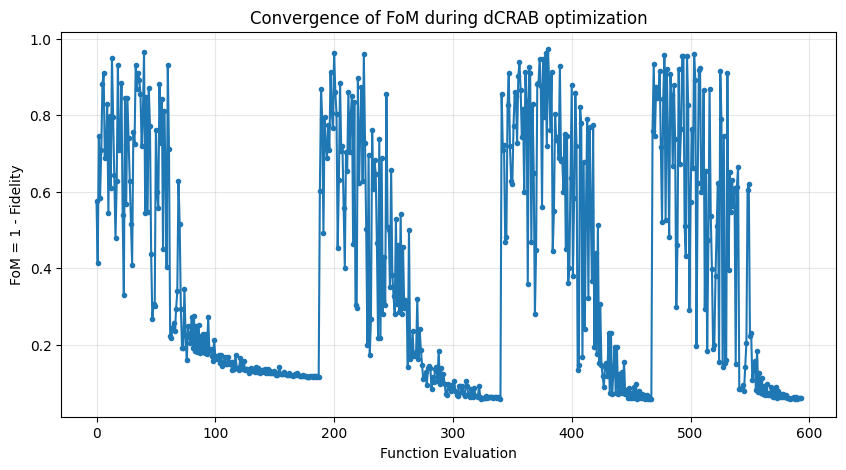

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


opt_alg = optimizer.get_optimization_algorithm()


fom_list = np.array(opt_alg.FoM_list)
N = len(fom_list)

plt.figure(figsize=(10,5))
plt.plot(fom_list, "-o", markersize=3)
plt.xlabel("Function Evaluation")
plt.ylabel("FoM = 1 - Fidelity")
plt.title("Convergence of FoM during dCRAB optimization")
plt.grid(alpha=0.3)
plt.show()


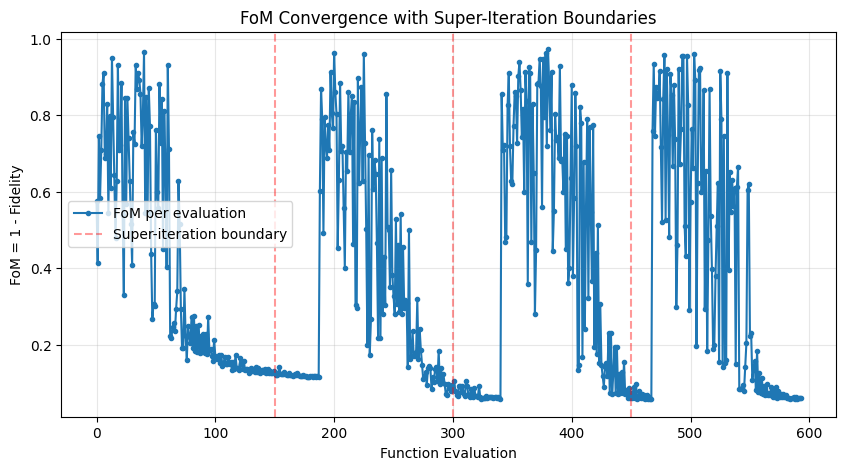

In [ ]:

max_eval = optimizer.get_optimization_algorithm().max_eval_total
SI = opt_dict["algorithm_settings"]["super_iteration_number"]
evals_per_SI = max_eval // SI

plt.figure(figsize=(10,5))
plt.plot(fom_list, "-o", markersize=3, label="FoM per evaluation")
for k in range(1, SI):
    plt.axvline(k * evals_per_SI, color="red", linestyle="--", alpha=0.4,
                label="Super-iteration boundary" if k==1 else None)

plt.xlabel("Function Evaluation")
plt.ylabel("FoM = 1 - Fidelity")
plt.title("FoM Convergence with Super-Iteration Boundaries")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


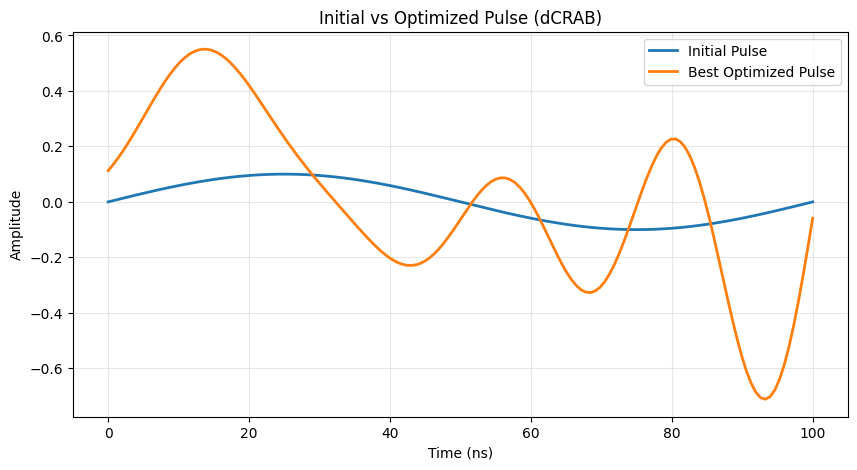

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


best_controls = opt_alg.get_best_controls()
best_pulse = np.array(best_controls["pulses"][0])
time_best = np.array(best_controls["timegrids"][0])


T = time_best[-1]
initial_pulse = 0.1 * np.sin(2 * np.pi * time_best / T)

# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(time_best, initial_pulse, label="Initial Pulse", linewidth=2)
plt.plot(time_best, best_pulse, label="Best Optimized Pulse", linewidth=2)
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.title("Initial vs Optimized Pulse (dCRAB)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
opt_alg = optimizer.get_optimization_algorithm()
fom_list = np.array(opt_alg.FoM_list)
controls = opt_alg.get_best_controls()
best_pulse = np.array(controls["pulses"][0])
best_time = np.array(controls["timegrids"][0])
print("Total evals:", len(fom_list))
print("Best FoM:", np.min(fom_list), "=> Best fidelity:", 1.0 - np.min(fom_list))


Total evals: 594
Best FoM: 0.05834124658356765 => Best fidelity: 0.9416587534164323


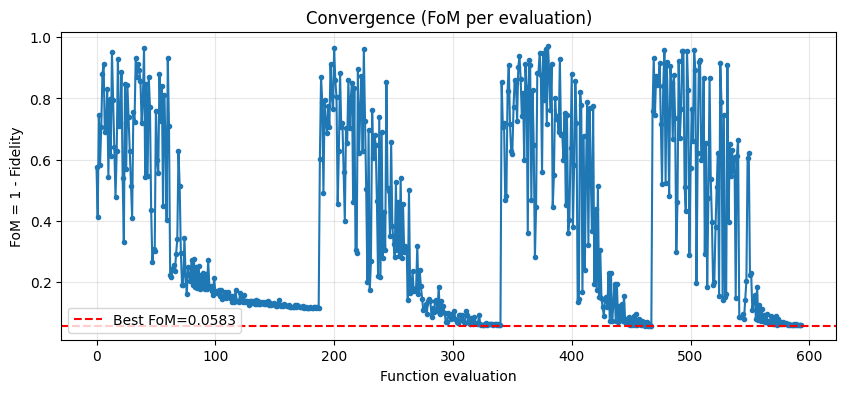

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(fom_list, '-o', markersize=3)
plt.axhline(np.min(fom_list), color='red', linestyle='--', label=f"Best FoM={np.min(fom_list):.4f}")
plt.xlabel("Function evaluation")
plt.ylabel("FoM = 1 - Fidelity")
plt.title("Convergence (FoM per evaluation)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


opt_alg = optimizer.get_optimization_algorithm()


fom_list = np.array(opt_alg.FoM_list)
N = len(fom_list)


df = pd.DataFrame({
    "evaluation": np.arange(N),
    "FoM": fom_list
})


window = 7
df["FoM_smooth"] = df["FoM"].rolling(window, center=True).mean()


display(df)


df.to_csv("fom_data.csv", index=False)
print("CSV saved as fom_data.csv")


,evaluation,FoM,FoM_smooth
0,0,0.575697,NaN
1,1,0.413080,NaN
2,2,0.746584,NaN
3,3,0.584410,0.688638
4,4,0.708332,0.704848
...,...,...,...
589,589,0.063502,0.061344
590,590,0.059284,0.061276
591,591,0.061897,NaN
592,592,0.060267,NaN


CSV saved as fom_data.csv
